In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
# from torchinfo import summary
import numpy as np

import cv2
import imageio
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# from transformer import ParticleTransformer

##Data Generation##


In [ ]:
from tqdm import tqdm
import torch
import datetime as dt
import os

OUTPUT_DIR = os.path.abspath("./data")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using torch device: {device}")

WIDTH, HEIGHT = 128, 128

torch.manual_seed(0)

def get_grav_acc(x, m, G):
    """
    Calculate gravitational acceleration of all points.
        x: (n, 2) array of positions
        m: (n,) array of masses
        G: gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and m.shape == (n,)

    epsilon = 20  # For buffering/smoothing effect

    # Calculate pairwise displacement vectors (x_i - x_j)
    dx = x[:, None, :] - x[None, :, :]  # Shape: (n, n, 2)
    d = torch.norm(dx, dim=2)

    mapped_masses = m[:, None].expand(n, n)

    F = G * dx * mapped_masses[:, :, None] / (d**3 + epsilon)[:, :, None]
    acc = torch.sum(F, dim=0) / m[:, None]

    return acc


def update_system(x, v, m, dt, G):
    """
    Update points due to gravitational attraction.
        x:  (n, 2) array of positions
        v:  (n, 2) array of velocities
        m:  (n,) array of masses
        dt: time step
        G:  gravitational constant
    """
    n = x.shape[0]
    assert x.shape == (n, 2) and v.shape == (n, 2) and m.shape == (n,)

    # Update positions and velocities using Verlet integration
    # https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet
    a = get_grav_acc(x, m, G)

    x_new = x + v * dt + 0.5 * a * dt**2
    a_new = get_grav_acc(x_new, m, G)
    v_new = v + 0.5 * (a + a_new) * dt

    return x_new, v_new


def generate_timeline(x0, v0, m, G, dt, F):
    """
    Generate one timeline of frames for gravity simulation.

    arguments:
        x0: (n, 2) array of initial positions
        v0: (n, 2) array of initial velocities
        m:  (n,) array of masses
        G:  gravitational constant
        dt: timestep per frame
        F:  frames to simulate for
    """
    n = x0.shape[0]
    assert x0.shape == (n, 2) and v0.shape == (n, 2) and m.shape == (n,)

    X = torch.zeros((F, n, 2)).to(device)
    V = torch.zeros((F, n, 2)).to(device)

    X[0] = x0
    # V[0] = v0
    m = m.to(device)

    for i in range(1, F):
        X[i], V[i] = update_system(X[i-1], V[i-1], m, dt, G)

    return {
        "dt": dt,
        "G": G,
        "m": m.cpu(),
        "X": X.cpu(),
        "V": V.cpu(),
    }


def points_to_histograms(X, weight, batch_size=64):
    """
    Vectorized histogram creation with batched frames to manage memory.
        i.e. "fast batched histograms"

    arguments:
        X:       (F, n, 2) tensor of positions across F frames
        weight:  (F, n) tensor of weights
        batch_size: number of frames to process at once
    """
    F, n, _ = X.shape
    assert tuple(weight.shape) == (F, n), "Weights must be of shape (F, n)"
    assert F % batch_size == 0

    result = torch.zeros(F, WIDTH * HEIGHT, device=X.device)
    for i in range(0, F, batch_size):
        batch_end = min(i + batch_size, F)

        X_slice = X[i:batch_end]   # shape: (f, n, 2) where f = batch_end - i
        mask = (0 <= X_slice[:,:,0]) & (X_slice[:,:,0] < WIDTH) \
             & (0 <= X_slice[:,:,1]) & (X_slice[:,:,1] < HEIGHT)

        net_weight = torch.zeros(batch_size, HEIGHT * WIDTH)

        # Assign flattened indices
        indices = (X_slice[:,:,0].long() * WIDTH + X_slice[:,:,1].long())  # shape: (f, n)
        indices = torch.clamp(indices, 0, WIDTH * HEIGHT - 1)

        net_weight.scatter_add_(1, indices, weight[i:batch_end] * mask)

        # Add back to results, cutting out extra index
        result[i:batch_end] += net_weight

    return result.reshape((F, HEIGHT, WIDTH))


def voxelize_timeline(timeline):
    """
    Converts point-cloud timeline to voxelized timeline.
    Output is (F, width, height, 4) tensor. Each (F, width, height)
        slice contains a 4-vector of features:
            [0] net x-momentum
            [1] net y-momentum
            [2] net mass
            [3] number of particles

    arguments:
        timeline: {
            "dt": dt,
            "G": "G",
            "m": (n,) array
            "X": (F, n, 2) array
            "V": (F, n, 2) array
        }
    """
    dt, G, m, X, V = [timeline[key] for key in ["dt", "G", "m", "X", "V"]]
    F, n, _ = X.shape

    p_x = V[:,:,0] * m[None,:]                  # x-momentum, (F, n)
    p_y = V[:,:,1] * m[None,:]                  # y-momentum, (F, n)
    m = m                                       # masses, (n,)
    ones = torch.ones((F, n))                   # to count objects, (F, n)

    p_x_channel = points_to_histograms(X, weight=p_x)
    p_y_channel = points_to_histograms(X, weight=p_y)
    m_channel = points_to_histograms(X, weight=torch.broadcast_to(m[None,:], (F, n)))
    count_channel = points_to_histograms(X, weight=ones)

    result = torch.stack((p_x_channel, p_y_channel, m_channel, count_channel), dim=1)
    return {
        "dt": dt,
        "G": G,
        "m": m,
        "frames": result,
    }


if __name__ == "__main__":
    F = 512             # Frames per timeline
    dt = 0.1            # Timestep per frame
    G = 100             # Gravitational constant
    n_samples = 100     # Number of timelines to generate

    n = 128             # Number of particles

    data_dir = f"n_{n}_dt_{dt}_F_{F}"
    os.makedirs(f"./data/{data_dir}/cloud", exist_ok=True)
    os.makedirs(f"./data/{data_dir}/voxel", exist_ok=True)

    for i in tqdm(range(n_samples), ncols=80):
        # Generate random positions
        x0 = torch.hstack([torch.rand((n, 1)) * WIDTH, torch.rand((n, 1)) * HEIGHT])

        # Generate random velocities
        v0 = torch.randn((n, 2)) * 2

        # Generate random masses according to log scale
        m = torch.exp(torch.randn((n,)) * 0.5 + 1)

        # Generate timeline
        cloud_timeline = generate_timeline(x0, v0, m, G, dt, F)
        torch.save(cloud_timeline, f"{OUTPUT_DIR}/{data_dir}/cloud/{i:>06}.pt")

        # # Generate voxelized timeline
        # voxel_timeline = voxelize_timeline(cloud_timeline)
        # torch.save(voxel_timeline, f"{OUTPUT_DIR}/{data_dir}/voxel/{i:>06}.pt")


Using torch device: cuda


100%|█████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


In [ ]:
# Render a data sample geneated by ./data_generation.py

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import imageio
from pathlib import Path


file = "n_128_dt_0.1_F_512/cloud/000000.pt"

timeline = torch.load(f"data/{file}", weights_only=True)
dt, G, m, X, _ = [timeline[key] for key in ["dt", "G", "m", "X", "V"]]

X = X.cpu()
sqrt_m = torch.sqrt(m)

F, n, _ = X.shape
# F is number of frames
# n is number of particles

x_min = 0
x_max = 512
y_min = 0
y_max = 512

frames = []
fig, ax = plt.subplots(figsize=(5.12, 5.12), dpi=100)
fig.patch.set_facecolor('black')

for i in tqdm(range(F), ncols=80):
    x = X[i]

    ax.clear()
    ax.set_xlim(0, 128)
    ax.set_ylim(0, 128)
    ax.scatter(x[:,0], x[:,1], color="white", s=sqrt_m)
    plt.axis("off")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height() + (4,))
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # Make the image writable by creating a copy
    image = image.copy()
    frames.append(image)

plt.close()

print(f"Finished rendering, saving to MP4...")

# Save frames as an animated GIF with looping
imageio.mimsave(f"./{Path(file).stem}.mp4", frames, fps=30) #, loop=0)

100%|█████████████████████████████████████████| 512/512 [00:15<00:00, 32.17it/s]


Finished rendering, saving to MP4...


##Load Data##


In [ ]:
# Load and prepare data
def load_particle_data(n_timelines, frames, n, dt):
    raw_inputs = []
    raw_outputs = []

    for i in tqdm(range(n_timelines)):
        timeline = torch.load(f"data/n_{n}_dt_{dt}_F_{frames}/cloud/{i:06}.pt", weights_only=True)

        X, V = timeline["X"], timeline["V"]
        m = torch.broadcast_to(timeline["m"][None,:,None], (frames, n, 1))
        features = torch.concat((X, V, m), dim=2)
        raw_inputs.append(features[:-1])
        raw_outputs.append(features[1:])

    raw_inputs = torch.concat(raw_inputs, dim=0)
    raw_outputs = torch.concat(raw_outputs, dim=0)
    return raw_inputs, raw_outputs

# Load data
n_timelines = 100
frames = 512
batch_size = 128
raw_inputs, raw_outputs = load_particle_data(n_timelines, frames, n, dt)
print(f"Raw inputs shape: {raw_inputs.shape} ({raw_inputs.nbytes / (1024**3):.3f} GB)")
print(f"Loaded {len(raw_inputs)} examples")

# Create dataset and dataloader
dataset = TensorDataset(raw_inputs, raw_outputs)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 100/100 [00:00<00:00, 383.93it/s]


Raw inputs shape: torch.Size([51100, 128, 5]) (0.122 GB)
Loaded 51100 examples


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_particles=128):
        super().__init__()
        position = torch.arange(max_particles).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_particles, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        residual = x

        # Linear transformations
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split into heads
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = self.dropout(torch.softmax(scores, dim=-1))

        # Apply attention to values
        context = torch.matmul(attention, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear layer with residual connection and layer norm
        output = self.layer_norm(residual + self.dropout(self.W_o(context)))
        return output

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),  # Changed from ReLU to GELU
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        # Multi-head attention
        x = self.attention(x)

        # Feed forward with residual connection and normalization
        residual = x
        x = self.feed_forward(x)
        x = self.layer_norm(residual + x)
        return x

class ParticleEmbedding(nn.Module):
    def __init__(self, input_dim, d_model):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )

    def forward(self, x):
        return self.embedding(x)

class ImprovedParticleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_layers=8, d_ff=2048, dropout=0.1):
        super().__init__()

        # Initial embedding layer
        self.embedding = ParticleEmbedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Output layers with skip connection
        self.output_layers = nn.Sequential(
            nn.Linear(d_model + input_dim, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, input_dim - 1)  # Excluding mass
        )

    def forward(self, x):
        # Store input for skip connection
        input_features = x

        # Embed the input
        x = self.embedding(x)
        x = self.pos_encoding(x)

        # Apply transformer blocks
        for block in self.transformer_blocks:
            x = block(x)

        # Concatenate original input features for skip connection
        x = torch.cat([x, input_features], dim=-1)

        # Predict next positions and velocities
        output = self.output_layers(x)
        return output

class CustomLoss(nn.Module):
    def __init__(self, position_weight=1.0, velocity_weight=0.5):
        super().__init__()
        self.position_weight = position_weight
        self.velocity_weight = velocity_weight

    def forward(self, pred, target):
        pos_pred, vel_pred = pred[..., :2], pred[..., 2:4]
        pos_target, vel_target = target[..., :2], target[..., 2:4]
        position_loss = nn.MSELoss()(pos_pred, pos_target)
        velocity_loss = nn.MSELoss()(vel_pred, vel_target)
        # print(f"Position loss: {position_loss.item():.4f}, Velocity loss: {velocity_loss.item():.4f}")
        total_loss = self.position_weight * position_loss + self.velocity_weight * velocity_loss
        return total_loss

def train_model_with_scheduler(model, dataloader, epochs, device, warmup_steps=1000):
    # Initialize optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=3e-4,
        epochs=epochs,
        steps_per_epoch=len(dataloader),
        pct_start=0.1
    )

    loss_fun = CustomLoss(position_weight=1.0, velocity_weight=0.5)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fun(outputs, targets[:,:,:-1])

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            loss_history.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.6f}")

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return loss_history

# Training setup and execution
input_dim = raw_inputs.shape[-1]
model = ImprovedParticleTransformer(
    input_dim=input_dim,
    d_model=512,
    num_heads=8,
    num_layers=8,
    d_ff=2048,
    dropout=0.1
).to(device)

dataset = TensorDataset(raw_inputs, raw_outputs)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, pin_memory=True)

loss_history = train_model_with_scheduler(model, dataloader, epochs=5, device=device)

Epoch [1/5]:   0%|          | 0/400 [00:00<?, ?it/s]

Position loss: 8161.3071, Velocity loss: 167.9016


Epoch [1/5]:   0%|          | 1/400 [00:01<09:26,  1.42s/it, loss=8245.2578, lr=0.000012]

Position loss: 8427.6797, Velocity loss: 166.6660


Epoch [1/5]:   0%|          | 2/400 [00:02<06:54,  1.04s/it, loss=8511.0127, lr=0.000012]

Position loss: 7899.9351, Velocity loss: 162.8533


Epoch [1/5]:   1%|          | 3/400 [00:02<06:10,  1.07it/s, loss=7981.3618, lr=0.000012]

Position loss: 7620.8711, Velocity loss: 167.4341


Epoch [1/5]:   1%|          | 4/400 [00:03<05:46,  1.14it/s, loss=7704.5879, lr=0.000012]

Position loss: 8753.0430, Velocity loss: 174.1700


Epoch [1/5]:   1%|▏         | 5/400 [00:04<05:33,  1.18it/s, loss=8840.1279, lr=0.000012]

Position loss: 8342.9551, Velocity loss: 173.0219


Epoch [1/5]:   2%|▏         | 6/400 [00:05<05:25,  1.21it/s, loss=8429.4658, lr=0.000013]

Position loss: 8349.3428, Velocity loss: 166.5763


Epoch [1/5]:   2%|▏         | 7/400 [00:06<05:19,  1.23it/s, loss=8432.6309, lr=0.000013]

Position loss: 8093.1787, Velocity loss: 170.7442


Epoch [1/5]:   2%|▏         | 8/400 [00:06<05:16,  1.24it/s, loss=8178.5508, lr=0.000013]

Position loss: 8454.6572, Velocity loss: 172.2276


Epoch [1/5]:   2%|▏         | 9/400 [00:07<05:13,  1.25it/s, loss=8540.7715, lr=0.000013]

Position loss: 7794.4922, Velocity loss: 161.1649


Epoch [1/5]:   2%|▎         | 10/400 [00:08<05:12,  1.25it/s, loss=7875.0747, lr=0.000014]

Position loss: 8700.7715, Velocity loss: 172.8703


Epoch [1/5]:   3%|▎         | 11/400 [00:09<05:11,  1.25it/s, loss=8787.2070, lr=0.000014]

Position loss: 7602.0542, Velocity loss: 171.3957


Epoch [1/5]:   3%|▎         | 12/400 [00:10<05:10,  1.25it/s, loss=7687.7520, lr=0.000015]

Position loss: 8169.7227, Velocity loss: 168.1477


Epoch [1/5]:   3%|▎         | 13/400 [00:10<05:09,  1.25it/s, loss=8253.7969, lr=0.000015]

Position loss: 7625.1943, Velocity loss: 165.5070


Epoch [1/5]:   4%|▎         | 14/400 [00:11<05:08,  1.25it/s, loss=7707.9478, lr=0.000016]

Position loss: 7396.2578, Velocity loss: 176.9207


Epoch [1/5]:   4%|▍         | 15/400 [00:12<05:07,  1.25it/s, loss=7484.7183, lr=0.000016]

Position loss: 7758.8213, Velocity loss: 179.0881


Epoch [1/5]:   4%|▍         | 16/400 [00:13<05:06,  1.25it/s, loss=7848.3652, lr=0.000017]

Position loss: 7833.0869, Velocity loss: 163.4001


Epoch [1/5]:   4%|▍         | 17/400 [00:14<05:06,  1.25it/s, loss=7914.7871, lr=0.000017]

Position loss: 8245.0176, Velocity loss: 162.5404


Epoch [1/5]:   4%|▍         | 18/400 [00:14<05:05,  1.25it/s, loss=8326.2881, lr=0.000018]

Position loss: 8152.6450, Velocity loss: 163.7059


Epoch [1/5]:   5%|▍         | 19/400 [00:15<05:04,  1.25it/s, loss=8234.4980, lr=0.000018]

Position loss: 8320.7168, Velocity loss: 173.8336


Epoch [1/5]:   5%|▌         | 20/400 [00:16<05:04,  1.25it/s, loss=8407.6338, lr=0.000019]

Position loss: 8845.3115, Velocity loss: 168.3943


Epoch [1/5]:   5%|▌         | 21/400 [00:17<05:04,  1.25it/s, loss=8929.5088, lr=0.000020]

Position loss: 7912.0830, Velocity loss: 167.5078


Epoch [1/5]:   6%|▌         | 22/400 [00:18<05:04,  1.24it/s, loss=7995.8369, lr=0.000021]

Position loss: 8363.7988, Velocity loss: 166.4603


Epoch [1/5]:   6%|▌         | 23/400 [00:18<05:03,  1.24it/s, loss=8447.0293, lr=0.000021]

Position loss: 8096.0830, Velocity loss: 171.8510


Epoch [1/5]:   6%|▌         | 24/400 [00:19<05:03,  1.24it/s, loss=8182.0083, lr=0.000022]

Position loss: 7607.8867, Velocity loss: 166.4741


Epoch [1/5]:   6%|▋         | 25/400 [00:20<05:03,  1.24it/s, loss=7691.1235, lr=0.000023]

Position loss: 8010.7236, Velocity loss: 171.5461


Epoch [1/5]:   6%|▋         | 26/400 [00:21<05:03,  1.23it/s, loss=8096.4966, lr=0.000024]

Position loss: 7480.8457, Velocity loss: 167.2830


Epoch [1/5]:   7%|▋         | 27/400 [00:22<05:02,  1.23it/s, loss=7564.4873, lr=0.000025]

Position loss: 8200.2207, Velocity loss: 163.5580


Epoch [1/5]:   7%|▋         | 28/400 [00:23<05:01,  1.23it/s, loss=8282.0000, lr=0.000026]

Position loss: 8384.1445, Velocity loss: 162.4330


Epoch [1/5]:   7%|▋         | 29/400 [00:23<05:00,  1.23it/s, loss=8465.3613, lr=0.000027]

Position loss: 8229.6631, Velocity loss: 164.7124


Epoch [1/5]:   8%|▊         | 30/400 [00:24<05:00,  1.23it/s, loss=8312.0195, lr=0.000028]

Position loss: 7508.2402, Velocity loss: 167.9785


Epoch [1/5]:   8%|▊         | 31/400 [00:25<04:59,  1.23it/s, loss=7592.2295, lr=0.000029]

Position loss: 8021.4819, Velocity loss: 170.4072


Epoch [1/5]:   8%|▊         | 32/400 [00:26<04:59,  1.23it/s, loss=8106.6855, lr=0.000030]

Position loss: 8034.0117, Velocity loss: 163.3546


Epoch [1/5]:   8%|▊         | 33/400 [00:27<04:59,  1.23it/s, loss=8115.6890, lr=0.000031]

Position loss: 7416.2236, Velocity loss: 155.0396


Epoch [1/5]:   8%|▊         | 34/400 [00:27<04:58,  1.23it/s, loss=7493.7437, lr=0.000032]

Position loss: 7429.5581, Velocity loss: 172.3104


Epoch [1/5]:   9%|▉         | 35/400 [00:28<04:58,  1.22it/s, loss=7515.7134, lr=0.000033]

Position loss: 7288.1611, Velocity loss: 162.7216


Epoch [1/5]:   9%|▉         | 36/400 [00:29<04:57,  1.22it/s, loss=7369.5220, lr=0.000035]

Position loss: 7678.6191, Velocity loss: 157.6949


Epoch [1/5]:   9%|▉         | 37/400 [00:30<04:57,  1.22it/s, loss=7757.4668, lr=0.000036]

Position loss: 7218.1777, Velocity loss: 161.1496


Epoch [1/5]:  10%|▉         | 38/400 [00:31<04:56,  1.22it/s, loss=7298.7524, lr=0.000037]

Position loss: 6914.0068, Velocity loss: 160.7642


Epoch [1/5]:  10%|▉         | 39/400 [00:32<04:56,  1.22it/s, loss=6994.3892, lr=0.000038]

Position loss: 7775.1230, Velocity loss: 163.2543


Epoch [1/5]:  10%|█         | 40/400 [00:32<04:56,  1.22it/s, loss=7856.7500, lr=0.000040]

Position loss: 7663.8394, Velocity loss: 165.0764


Epoch [1/5]:  10%|█         | 41/400 [00:33<04:56,  1.21it/s, loss=7746.3774, lr=0.000041]

Position loss: 8211.9004, Velocity loss: 177.4228


Epoch [1/5]:  10%|█         | 42/400 [00:34<04:55,  1.21it/s, loss=8300.6113, lr=0.000043]

Position loss: 7664.7866, Velocity loss: 169.7056


Epoch [1/5]:  11%|█         | 43/400 [00:35<04:54,  1.21it/s, loss=7749.6396, lr=0.000044]

Position loss: 7243.1968, Velocity loss: 169.3459


Epoch [1/5]:  11%|█         | 44/400 [00:36<04:54,  1.21it/s, loss=7327.8696, lr=0.000045]

Position loss: 7693.9810, Velocity loss: 159.8570


Epoch [1/5]:  11%|█▏        | 45/400 [00:36<04:53,  1.21it/s, loss=7773.9097, lr=0.000047]

Position loss: 7909.7949, Velocity loss: 161.1894


Epoch [1/5]:  12%|█▏        | 46/400 [00:37<04:53,  1.21it/s, loss=7990.3896, lr=0.000048]

Position loss: 7734.5352, Velocity loss: 161.0438


Epoch [1/5]:  12%|█▏        | 47/400 [00:38<04:53,  1.20it/s, loss=7815.0571, lr=0.000050]

Position loss: 7219.7705, Velocity loss: 157.2995


Epoch [1/5]:  12%|█▏        | 48/400 [00:39<04:52,  1.20it/s, loss=7298.4204, lr=0.000051]

Position loss: 7737.8105, Velocity loss: 165.1201


Epoch [1/5]:  12%|█▏        | 49/400 [00:40<04:51,  1.20it/s, loss=7820.3706, lr=0.000053]

Position loss: 7246.8047, Velocity loss: 161.9210


Epoch [1/5]:  12%|█▎        | 50/400 [00:41<04:51,  1.20it/s, loss=7327.7651, lr=0.000055]

Position loss: 6667.3760, Velocity loss: 160.3208


Epoch [1/5]:  13%|█▎        | 51/400 [00:41<04:50,  1.20it/s, loss=6747.5366, lr=0.000056]

Position loss: 7528.9717, Velocity loss: 164.0394


Epoch [1/5]:  13%|█▎        | 52/400 [00:42<04:50,  1.20it/s, loss=7610.9912, lr=0.000058]

Position loss: 7245.8896, Velocity loss: 167.9413


Epoch [1/5]:  13%|█▎        | 53/400 [00:43<04:49,  1.20it/s, loss=7329.8604, lr=0.000060]

Position loss: 7802.4175, Velocity loss: 166.8613


Epoch [1/5]:  14%|█▎        | 54/400 [00:44<04:48,  1.20it/s, loss=7885.8481, lr=0.000061]

Position loss: 7720.5830, Velocity loss: 160.0324


Epoch [1/5]:  14%|█▍        | 55/400 [00:45<04:49,  1.19it/s, loss=7800.5991, lr=0.000063]

Position loss: 7046.8389, Velocity loss: 166.1989


Epoch [1/5]:  14%|█▍        | 56/400 [00:46<04:48,  1.19it/s, loss=7129.9385, lr=0.000065]

Position loss: 7386.1602, Velocity loss: 160.4976


Epoch [1/5]:  14%|█▍        | 57/400 [00:47<04:47,  1.19it/s, loss=7466.4092, lr=0.000066]

Position loss: 6870.6504, Velocity loss: 160.6418


Epoch [1/5]:  14%|█▍        | 58/400 [00:47<04:47,  1.19it/s, loss=6950.9712, lr=0.000068]

Position loss: 6901.3174, Velocity loss: 164.0478


Epoch [1/5]:  15%|█▍        | 59/400 [00:48<04:46,  1.19it/s, loss=6983.3413, lr=0.000070]

Position loss: 7602.3198, Velocity loss: 157.7219


Epoch [1/5]:  15%|█▌        | 60/400 [00:49<04:47,  1.18it/s, loss=7681.1807, lr=0.000072]

Position loss: 7004.9668, Velocity loss: 156.6566


Epoch [1/5]:  15%|█▌        | 61/400 [00:50<04:46,  1.18it/s, loss=7083.2949, lr=0.000074]

Position loss: 7106.5068, Velocity loss: 161.9745


Epoch [1/5]:  16%|█▌        | 62/400 [00:51<04:46,  1.18it/s, loss=7187.4941, lr=0.000076]

Position loss: 7253.5732, Velocity loss: 160.8931


Epoch [1/5]:  16%|█▌        | 63/400 [00:52<04:45,  1.18it/s, loss=7334.0200, lr=0.000078]

Position loss: 6682.4458, Velocity loss: 156.8818


Epoch [1/5]:  16%|█▌        | 64/400 [00:52<04:45,  1.18it/s, loss=6760.8867, lr=0.000079]

Position loss: 6559.4355, Velocity loss: 161.3805


Epoch [1/5]:  16%|█▋        | 65/400 [00:53<04:44,  1.18it/s, loss=6640.1260, lr=0.000081]

Position loss: 6638.7983, Velocity loss: 154.5451


Epoch [1/5]:  16%|█▋        | 66/400 [00:54<04:44,  1.17it/s, loss=6716.0708, lr=0.000083]

Position loss: 6738.7480, Velocity loss: 161.5488


Epoch [1/5]:  17%|█▋        | 67/400 [00:55<04:44,  1.17it/s, loss=6819.5225, lr=0.000085]

Position loss: 6667.8281, Velocity loss: 154.0034


Epoch [1/5]:  17%|█▋        | 68/400 [00:56<04:44,  1.17it/s, loss=6744.8301, lr=0.000087]

Position loss: 7369.1528, Velocity loss: 158.0523


Epoch [1/5]:  17%|█▋        | 69/400 [00:57<04:44,  1.16it/s, loss=7448.1792, lr=0.000089]

Position loss: 6753.7188, Velocity loss: 160.0325


Epoch [1/5]:  18%|█▊        | 70/400 [00:58<04:44,  1.16it/s, loss=6833.7349, lr=0.000091]

Position loss: 6187.8760, Velocity loss: 151.4533


Epoch [1/5]:  18%|█▊        | 71/400 [00:58<04:43,  1.16it/s, loss=6263.6025, lr=0.000093]

Position loss: 7358.2168, Velocity loss: 159.5589


Epoch [1/5]:  18%|█▊        | 72/400 [00:59<04:43,  1.16it/s, loss=7437.9961, lr=0.000095]

Position loss: 6500.6934, Velocity loss: 161.2819


Epoch [1/5]:  18%|█▊        | 73/400 [01:00<04:42,  1.16it/s, loss=6581.3345, lr=0.000097]

Position loss: 6109.3901, Velocity loss: 158.8224


Epoch [1/5]:  18%|█▊        | 74/400 [01:01<04:42,  1.16it/s, loss=6188.8013, lr=0.000100]

Position loss: 6558.9443, Velocity loss: 163.3552


Epoch [1/5]:  19%|█▉        | 75/400 [01:02<04:41,  1.15it/s, loss=6640.6221, lr=0.000102]

Position loss: 6355.9551, Velocity loss: 164.5898


Epoch [1/5]:  19%|█▉        | 76/400 [01:03<04:41,  1.15it/s, loss=6438.2500, lr=0.000104]

Position loss: 6534.2852, Velocity loss: 162.5116


Epoch [1/5]:  19%|█▉        | 77/400 [01:04<04:41,  1.15it/s, loss=6615.5410, lr=0.000106]

Position loss: 6497.5977, Velocity loss: 153.3414


Epoch [1/5]:  20%|█▉        | 78/400 [01:05<04:40,  1.15it/s, loss=6574.2686, lr=0.000108]

Position loss: 6360.1406, Velocity loss: 154.0245


Epoch [1/5]:  20%|█▉        | 79/400 [01:05<04:39,  1.15it/s, loss=6437.1528, lr=0.000110]

Position loss: 6562.4521, Velocity loss: 149.6519


Epoch [1/5]:  20%|██        | 80/400 [01:06<04:38,  1.15it/s, loss=6637.2783, lr=0.000112]

Position loss: 6238.8516, Velocity loss: 153.9769


Epoch [1/5]:  20%|██        | 81/400 [01:07<04:38,  1.15it/s, loss=6315.8398, lr=0.000115]

Position loss: 5845.1064, Velocity loss: 154.9637


Epoch [1/5]:  20%|██        | 82/400 [01:08<04:37,  1.15it/s, loss=5922.5884, lr=0.000117]

Position loss: 6142.8599, Velocity loss: 155.1977


Epoch [1/5]:  21%|██        | 83/400 [01:09<04:36,  1.15it/s, loss=6220.4585, lr=0.000119]

Position loss: 6108.0957, Velocity loss: 157.7395


Epoch [1/5]:  21%|██        | 84/400 [01:10<04:35,  1.15it/s, loss=6186.9653, lr=0.000121]

Position loss: 5937.5195, Velocity loss: 156.7638


Epoch [1/5]:  21%|██▏       | 85/400 [01:11<04:33,  1.15it/s, loss=6015.9014, lr=0.000123]

Position loss: 5890.1533, Velocity loss: 147.1637


Epoch [1/5]:  22%|██▏       | 86/400 [01:12<04:32,  1.15it/s, loss=5963.7354, lr=0.000126]

Position loss: 5615.9775, Velocity loss: 156.9187


Epoch [1/5]:  22%|██▏       | 87/400 [01:12<04:31,  1.15it/s, loss=5694.4370, lr=0.000128]

Position loss: 6555.8418, Velocity loss: 152.5762


Epoch [1/5]:  22%|██▏       | 88/400 [01:13<04:29,  1.16it/s, loss=6632.1299, lr=0.000130]

Position loss: 6019.6592, Velocity loss: 145.7521


Epoch [1/5]:  22%|██▏       | 89/400 [01:14<04:28,  1.16it/s, loss=6092.5352, lr=0.000132]

Position loss: 6378.5947, Velocity loss: 142.8772


Epoch [1/5]:  22%|██▎       | 90/400 [01:15<04:26,  1.16it/s, loss=6450.0332, lr=0.000134]

Position loss: 5582.4844, Velocity loss: 156.4032


Epoch [1/5]:  23%|██▎       | 91/400 [01:16<04:25,  1.16it/s, loss=5660.6860, lr=0.000137]

Position loss: 5636.3247, Velocity loss: 145.4071


Epoch [1/5]:  23%|██▎       | 92/400 [01:17<04:23,  1.17it/s, loss=5709.0283, lr=0.000139]

Position loss: 5297.7778, Velocity loss: 153.3873


Epoch [1/5]:  23%|██▎       | 93/400 [01:18<04:22,  1.17it/s, loss=5374.4717, lr=0.000141]

Position loss: 6027.4258, Velocity loss: 144.7942


Epoch [1/5]:  24%|██▎       | 94/400 [01:18<04:20,  1.17it/s, loss=6099.8228, lr=0.000144]

Position loss: 5494.4058, Velocity loss: 155.0423


Epoch [1/5]:  24%|██▍       | 95/400 [01:19<04:19,  1.18it/s, loss=5571.9268, lr=0.000146]

Position loss: 5617.3623, Velocity loss: 147.4856


Epoch [1/5]:  24%|██▍       | 96/400 [01:20<04:17,  1.18it/s, loss=5691.1050, lr=0.000148]

Position loss: 5532.3618, Velocity loss: 155.0433


Epoch [1/5]:  24%|██▍       | 97/400 [01:21<04:17,  1.18it/s, loss=5609.8833, lr=0.000150]

Position loss: 5578.0864, Velocity loss: 146.9276


Epoch [1/5]:  24%|██▍       | 98/400 [01:22<04:15,  1.18it/s, loss=5651.5503, lr=0.000153]

Position loss: 5400.5273, Velocity loss: 145.9574


Epoch [1/5]:  25%|██▍       | 99/400 [01:23<04:14,  1.18it/s, loss=5473.5059, lr=0.000155]

Position loss: 5350.7100, Velocity loss: 147.3022


Epoch [1/5]:  25%|██▌       | 100/400 [01:23<04:13,  1.18it/s, loss=5424.3608, lr=0.000157]

Position loss: 4629.3916, Velocity loss: 148.6982


Epoch [1/5]:  25%|██▌       | 101/400 [01:24<04:12,  1.19it/s, loss=4703.7407, lr=0.000159]

Position loss: 4914.1689, Velocity loss: 143.9287


Epoch [1/5]:  26%|██▌       | 102/400 [01:25<04:10,  1.19it/s, loss=4986.1333, lr=0.000162]

Position loss: 5253.3193, Velocity loss: 148.1947


Epoch [1/5]:  26%|██▌       | 103/400 [01:26<04:09,  1.19it/s, loss=5327.4165, lr=0.000164]

Position loss: 4360.5713, Velocity loss: 147.9221


Epoch [1/5]:  26%|██▌       | 104/400 [01:27<04:08,  1.19it/s, loss=4434.5322, lr=0.000166]

Position loss: 4602.2305, Velocity loss: 144.3491


Epoch [1/5]:  26%|██▋       | 105/400 [01:28<04:07,  1.19it/s, loss=4674.4053, lr=0.000168]

Position loss: 4568.6836, Velocity loss: 144.5481


Epoch [1/5]:  26%|██▋       | 106/400 [01:28<04:06,  1.19it/s, loss=4640.9575, lr=0.000171]

Position loss: 4229.4019, Velocity loss: 148.2380


Epoch [1/5]:  27%|██▋       | 107/400 [01:29<04:05,  1.20it/s, loss=4303.5210, lr=0.000173]

Position loss: 4784.1934, Velocity loss: 142.4008


Epoch [1/5]:  27%|██▋       | 108/400 [01:30<04:04,  1.20it/s, loss=4855.3936, lr=0.000175]

Position loss: 4481.5513, Velocity loss: 141.9409


Epoch [1/5]:  27%|██▋       | 109/400 [01:31<04:03,  1.20it/s, loss=4552.5215, lr=0.000178]

Position loss: 4388.3760, Velocity loss: 137.3925


Epoch [1/5]:  28%|██▊       | 110/400 [01:32<04:01,  1.20it/s, loss=4457.0723, lr=0.000180]

Position loss: 4292.0146, Velocity loss: 139.1283


Epoch [1/5]:  28%|██▊       | 111/400 [01:33<04:00,  1.20it/s, loss=4361.5786, lr=0.000182]

Position loss: 4365.7539, Velocity loss: 143.5532


Epoch [1/5]:  28%|██▊       | 112/400 [01:33<04:00,  1.20it/s, loss=4437.5303, lr=0.000184]

Position loss: 4174.8813, Velocity loss: 142.1472


Epoch [1/5]:  28%|██▊       | 113/400 [01:34<03:59,  1.20it/s, loss=4245.9551, lr=0.000186]

Position loss: 3748.3875, Velocity loss: 142.0471


Epoch [1/5]:  28%|██▊       | 114/400 [01:35<03:58,  1.20it/s, loss=3819.4111, lr=0.000189]

Position loss: 3319.7546, Velocity loss: 135.8343


Epoch [1/5]:  29%|██▉       | 115/400 [01:36<03:56,  1.20it/s, loss=3387.6719, lr=0.000191]

Position loss: 3575.2480, Velocity loss: 143.7972


Epoch [1/5]:  29%|██▉       | 116/400 [01:37<03:55,  1.20it/s, loss=3647.1467, lr=0.000193]

Position loss: 3606.1636, Velocity loss: 138.3880


Epoch [1/5]:  29%|██▉       | 117/400 [01:38<03:55,  1.20it/s, loss=3675.3577, lr=0.000195]

Position loss: 3764.6233, Velocity loss: 144.6718


Epoch [1/5]:  30%|██▉       | 118/400 [01:38<03:54,  1.20it/s, loss=3836.9592, lr=0.000197]

Position loss: 3908.7166, Velocity loss: 137.6503


Epoch [1/5]:  30%|██▉       | 119/400 [01:39<03:53,  1.20it/s, loss=3977.5417, lr=0.000200]

Position loss: 3464.4089, Velocity loss: 142.0212


Epoch [1/5]:  30%|███       | 120/400 [01:40<03:52,  1.20it/s, loss=3535.4194, lr=0.000202]

Position loss: 3554.8196, Velocity loss: 137.6435


Epoch [1/5]:  30%|███       | 121/400 [01:41<03:52,  1.20it/s, loss=3623.6414, lr=0.000204]

Position loss: 3282.3616, Velocity loss: 140.2493


Epoch [1/5]:  30%|███       | 122/400 [01:42<03:51,  1.20it/s, loss=3352.4863, lr=0.000206]

Position loss: 3490.1450, Velocity loss: 142.3384


Epoch [1/5]:  31%|███       | 123/400 [01:43<03:50,  1.20it/s, loss=3561.3142, lr=0.000208]

Position loss: 2825.3789, Velocity loss: 129.1004


Epoch [1/5]:  31%|███       | 124/400 [01:43<03:49,  1.20it/s, loss=2889.9292, lr=0.000210]

Position loss: 2710.5913, Velocity loss: 137.4554


Epoch [1/5]:  31%|███▏      | 125/400 [01:44<03:48,  1.20it/s, loss=2779.3191, lr=0.000212]

Position loss: 3092.5264, Velocity loss: 126.9650


Epoch [1/5]:  32%|███▏      | 126/400 [01:45<03:48,  1.20it/s, loss=3156.0088, lr=0.000215]

Position loss: 3416.3064, Velocity loss: 130.9007


Epoch [1/5]:  32%|███▏      | 127/400 [01:46<03:47,  1.20it/s, loss=3481.7568, lr=0.000217]

Position loss: 3001.0884, Velocity loss: 129.2731


Epoch [1/5]:  32%|███▏      | 128/400 [01:47<03:46,  1.20it/s, loss=3065.7249, lr=0.000219]

Position loss: 2394.3596, Velocity loss: 134.2111


Epoch [1/5]:  32%|███▏      | 129/400 [01:48<03:45,  1.20it/s, loss=2461.4651, lr=0.000221]

Position loss: 2662.6396, Velocity loss: 131.2578


Epoch [1/5]:  32%|███▎      | 130/400 [01:48<03:44,  1.20it/s, loss=2728.2686, lr=0.000223]

Position loss: 2626.1621, Velocity loss: 124.2063


Epoch [1/5]:  33%|███▎      | 131/400 [01:49<03:43,  1.20it/s, loss=2688.2651, lr=0.000225]

Position loss: 2336.1221, Velocity loss: 124.4926


Epoch [1/5]:  33%|███▎      | 132/400 [01:50<03:43,  1.20it/s, loss=2398.3684, lr=0.000227]

Position loss: 2223.4944, Velocity loss: 126.6691


Epoch [1/5]:  33%|███▎      | 133/400 [01:51<03:42,  1.20it/s, loss=2286.8289, lr=0.000229]

Position loss: 2813.7874, Velocity loss: 127.6142


Epoch [1/5]:  34%|███▎      | 134/400 [01:52<03:41,  1.20it/s, loss=2877.5945, lr=0.000231]

Position loss: 1966.0975, Velocity loss: 132.4528


Epoch [1/5]:  34%|███▍      | 135/400 [01:53<03:41,  1.20it/s, loss=2032.3240, lr=0.000233]

Position loss: 2110.1636, Velocity loss: 129.1645


Epoch [1/5]:  34%|███▍      | 136/400 [01:53<03:40,  1.20it/s, loss=2174.7458, lr=0.000234]

Position loss: 2162.4468, Velocity loss: 130.7118


Epoch [1/5]:  34%|███▍      | 137/400 [01:54<03:39,  1.20it/s, loss=2227.8027, lr=0.000236]

Position loss: 2105.7324, Velocity loss: 129.6869


Epoch [1/5]:  34%|███▍      | 138/400 [01:55<03:38,  1.20it/s, loss=2170.5759, lr=0.000238]

Position loss: 2299.3408, Velocity loss: 115.1635


Epoch [1/5]:  35%|███▍      | 139/400 [01:56<03:37,  1.20it/s, loss=2356.9226, lr=0.000240]

Position loss: 2106.4614, Velocity loss: 120.3051


Epoch [1/5]:  35%|███▌      | 140/400 [01:57<03:36,  1.20it/s, loss=2166.6140, lr=0.000242]

Position loss: 2379.3196, Velocity loss: 113.0048


Epoch [1/5]:  35%|███▌      | 141/400 [01:58<03:36,  1.20it/s, loss=2435.8220, lr=0.000244]

Position loss: 1994.3536, Velocity loss: 117.2365


Epoch [1/5]:  36%|███▌      | 142/400 [01:58<03:35,  1.20it/s, loss=2052.9719, lr=0.000246]

Position loss: 1963.6318, Velocity loss: 118.6507


Epoch [1/5]:  36%|███▌      | 143/400 [01:59<03:35,  1.19it/s, loss=2022.9572, lr=0.000247]

Position loss: 2236.2874, Velocity loss: 108.8062


Epoch [1/5]:  36%|███▌      | 144/400 [02:00<03:34,  1.19it/s, loss=2290.6904, lr=0.000249]

Position loss: 1788.6926, Velocity loss: 110.6892


Epoch [1/5]:  36%|███▋      | 145/400 [02:01<03:33,  1.19it/s, loss=1844.0372, lr=0.000251]

Position loss: 1616.5050, Velocity loss: 106.9651


Epoch [1/5]:  36%|███▋      | 146/400 [02:02<03:33,  1.19it/s, loss=1669.9875, lr=0.000252]

Position loss: 1979.7694, Velocity loss: 112.8174


Epoch [1/5]:  37%|███▋      | 147/400 [02:03<03:32,  1.19it/s, loss=2036.1781, lr=0.000254]

Position loss: 1788.9852, Velocity loss: 103.6467


Epoch [1/5]:  37%|███▋      | 148/400 [02:03<03:31,  1.19it/s, loss=1840.8086, lr=0.000256]

Position loss: 1700.3262, Velocity loss: 102.3625


Epoch [1/5]:  37%|███▋      | 149/400 [02:04<03:30,  1.19it/s, loss=1751.5074, lr=0.000257]

Position loss: 1564.9092, Velocity loss: 100.2136


Epoch [1/5]:  38%|███▊      | 150/400 [02:05<03:30,  1.19it/s, loss=1615.0160, lr=0.000259]

Position loss: 1753.8899, Velocity loss: 97.2194


Epoch [1/5]:  38%|███▊      | 151/400 [02:06<03:29,  1.19it/s, loss=1802.4996, lr=0.000261]

Position loss: 1554.0616, Velocity loss: 97.7599


Epoch [1/5]:  38%|███▊      | 152/400 [02:07<03:29,  1.19it/s, loss=1602.9417, lr=0.000262]

Position loss: 1652.8262, Velocity loss: 91.5919


Epoch [1/5]:  38%|███▊      | 153/400 [02:08<03:28,  1.19it/s, loss=1698.6222, lr=0.000264]

Position loss: 1350.7351, Velocity loss: 91.8506


Epoch [1/5]:  38%|███▊      | 154/400 [02:09<03:27,  1.19it/s, loss=1396.6604, lr=0.000265]

Position loss: 1409.8428, Velocity loss: 90.3370


Epoch [1/5]:  39%|███▉      | 155/400 [02:09<03:27,  1.18it/s, loss=1455.0112, lr=0.000267]

Position loss: 1496.8196, Velocity loss: 84.8444


Epoch [1/5]:  39%|███▉      | 156/400 [02:10<03:26,  1.18it/s, loss=1539.2418, lr=0.000268]

Position loss: 1437.1936, Velocity loss: 84.8140


Epoch [1/5]:  39%|███▉      | 157/400 [02:11<03:25,  1.18it/s, loss=1479.6006, lr=0.000269]

Position loss: 1412.1511, Velocity loss: 82.0999


Epoch [1/5]:  40%|███▉      | 158/400 [02:12<03:24,  1.18it/s, loss=1453.2010, lr=0.000271]

Position loss: 1209.6011, Velocity loss: 75.6102


Epoch [1/5]:  40%|███▉      | 159/400 [02:13<03:24,  1.18it/s, loss=1247.4062, lr=0.000272]

Position loss: 1382.4761, Velocity loss: 75.9257


Epoch [1/5]:  40%|████      | 160/400 [02:14<03:23,  1.18it/s, loss=1420.4390, lr=0.000274]

Position loss: 1312.9482, Velocity loss: 77.2333


Epoch [1/5]:  40%|████      | 161/400 [02:14<03:22,  1.18it/s, loss=1351.5649, lr=0.000275]

Position loss: 1145.8479, Velocity loss: 76.0978


Epoch [1/5]:  40%|████      | 162/400 [02:15<03:21,  1.18it/s, loss=1183.8969, lr=0.000276]

Position loss: 895.0848, Velocity loss: 67.2340


Epoch [1/5]:  41%|████      | 163/400 [02:16<03:20,  1.18it/s, loss=928.7018, lr=0.000277]

Position loss: 1162.7322, Velocity loss: 61.9939


Epoch [1/5]:  41%|████      | 164/400 [02:17<03:20,  1.18it/s, loss=1193.7291, lr=0.000279]

Position loss: 1171.9529, Velocity loss: 60.7947


Epoch [1/5]:  41%|████▏     | 165/400 [02:18<03:19,  1.18it/s, loss=1202.3502, lr=0.000280]

Position loss: 733.1562, Velocity loss: 58.2122


Epoch [1/5]:  42%|████▏     | 166/400 [02:19<03:18,  1.18it/s, loss=762.2623, lr=0.000281]

Position loss: 1026.7314, Velocity loss: 53.4248


Epoch [1/5]:  42%|████▏     | 167/400 [02:20<03:17,  1.18it/s, loss=1053.4438, lr=0.000282]

Position loss: 1044.3737, Velocity loss: 52.9831


Epoch [1/5]:  42%|████▏     | 168/400 [02:20<03:17,  1.18it/s, loss=1070.8652, lr=0.000283]

Position loss: 960.6580, Velocity loss: 44.7137


Epoch [1/5]:  42%|████▏     | 169/400 [02:21<03:16,  1.18it/s, loss=983.0148, lr=0.000284]

Position loss: 931.8260, Velocity loss: 43.9860


Epoch [1/5]:  42%|████▎     | 170/400 [02:22<03:15,  1.18it/s, loss=953.8191, lr=0.000285]

Position loss: 671.7144, Velocity loss: 43.3670


Epoch [1/5]:  43%|████▎     | 171/400 [02:23<03:14,  1.18it/s, loss=693.3979, lr=0.000286]

Position loss: 956.6537, Velocity loss: 42.3983


Epoch [1/5]:  43%|████▎     | 172/400 [02:24<03:13,  1.18it/s, loss=977.8528, lr=0.000287]

Position loss: 793.3182, Velocity loss: 41.8641


Epoch [1/5]:  43%|████▎     | 173/400 [02:25<03:12,  1.18it/s, loss=814.2502, lr=0.000288]

Position loss: 569.0422, Velocity loss: 44.2880


Epoch [1/5]:  44%|████▎     | 174/400 [02:26<03:12,  1.18it/s, loss=591.1862, lr=0.000289]

Position loss: 667.6349, Velocity loss: 40.9651


Epoch [1/5]:  44%|████▍     | 175/400 [02:26<03:11,  1.18it/s, loss=688.1174, lr=0.000290]

Position loss: 717.8458, Velocity loss: 40.7367


Epoch [1/5]:  44%|████▍     | 176/400 [02:27<03:10,  1.18it/s, loss=738.2142, lr=0.000291]

Position loss: 656.6251, Velocity loss: 42.6159


Epoch [1/5]:  44%|████▍     | 177/400 [02:28<03:09,  1.17it/s, loss=677.9330, lr=0.000291]

Position loss: 557.0950, Velocity loss: 39.6345


Epoch [1/5]:  44%|████▍     | 178/400 [02:29<03:08,  1.18it/s, loss=576.9122, lr=0.000292]

Position loss: 568.2108, Velocity loss: 40.6526


Epoch [1/5]:  45%|████▍     | 179/400 [02:30<03:07,  1.18it/s, loss=588.5371, lr=0.000293]

Position loss: 646.8467, Velocity loss: 40.6645


Epoch [1/5]:  45%|████▌     | 180/400 [02:31<03:06,  1.18it/s, loss=667.1790, lr=0.000294]

Position loss: 427.0965, Velocity loss: 33.9827


Epoch [1/5]:  45%|████▌     | 181/400 [02:31<03:06,  1.18it/s, loss=444.0879, lr=0.000294]

Position loss: 469.9670, Velocity loss: 33.4478


Epoch [1/5]:  46%|████▌     | 182/400 [02:32<03:05,  1.18it/s, loss=486.6909, lr=0.000295]

Position loss: 471.7438, Velocity loss: 34.0336


Epoch [1/5]:  46%|████▌     | 183/400 [02:33<03:04,  1.18it/s, loss=488.7606, lr=0.000295]

Position loss: 410.3452, Velocity loss: 30.6459


Epoch [1/5]:  46%|████▌     | 184/400 [02:34<03:03,  1.18it/s, loss=425.6682, lr=0.000296]

Position loss: 388.4073, Velocity loss: 28.8611


Epoch [1/5]:  46%|████▋     | 185/400 [02:35<03:02,  1.18it/s, loss=402.8379, lr=0.000296]

Position loss: 371.2261, Velocity loss: 27.5378


Epoch [1/5]:  46%|████▋     | 186/400 [02:36<03:01,  1.18it/s, loss=384.9950, lr=0.000297]

Position loss: 315.4651, Velocity loss: 24.3202


Epoch [1/5]:  47%|████▋     | 187/400 [02:37<03:00,  1.18it/s, loss=327.6252, lr=0.000297]

Position loss: 297.4926, Velocity loss: 24.6389


Epoch [1/5]:  47%|████▋     | 188/400 [02:37<02:59,  1.18it/s, loss=309.8120, lr=0.000298]

Position loss: 282.4199, Velocity loss: 23.4471


Epoch [1/5]:  47%|████▋     | 189/400 [02:38<02:59,  1.18it/s, loss=294.1435, lr=0.000298]

Position loss: 292.9832, Velocity loss: 24.4281


Epoch [1/5]:  48%|████▊     | 190/400 [02:39<02:58,  1.18it/s, loss=305.1972, lr=0.000299]

Position loss: 305.4217, Velocity loss: 23.5516


Epoch [1/5]:  48%|████▊     | 191/400 [02:40<02:57,  1.18it/s, loss=317.1975, lr=0.000299]

Position loss: 351.1042, Velocity loss: 24.4077


Epoch [1/5]:  48%|████▊     | 192/400 [02:41<02:56,  1.18it/s, loss=363.3081, lr=0.000299]

Position loss: 366.6373, Velocity loss: 25.7186


Epoch [1/5]:  48%|████▊     | 193/400 [02:42<02:55,  1.18it/s, loss=379.4966, lr=0.000299]

Position loss: 194.9962, Velocity loss: 26.6336


Epoch [1/5]:  48%|████▊     | 194/400 [02:43<02:54,  1.18it/s, loss=208.3130, lr=0.000300]

Position loss: 262.4876, Velocity loss: 28.7414


Epoch [1/5]:  49%|████▉     | 195/400 [02:43<02:53,  1.18it/s, loss=276.8583, lr=0.000300]

Position loss: 170.9083, Velocity loss: 28.6533


Epoch [1/5]:  49%|████▉     | 196/400 [02:44<02:52,  1.18it/s, loss=185.2349, lr=0.000300]

Position loss: 172.3886, Velocity loss: 27.1474


Epoch [1/5]:  49%|████▉     | 197/400 [02:45<02:51,  1.18it/s, loss=185.9623, lr=0.000300]

Position loss: 194.8162, Velocity loss: 26.3178


Epoch [1/5]:  50%|████▉     | 198/400 [02:46<02:50,  1.18it/s, loss=207.9751, lr=0.000300]

Position loss: 191.4598, Velocity loss: 25.0198


Epoch [1/5]:  50%|████▉     | 199/400 [02:47<02:49,  1.18it/s, loss=203.9697, lr=0.000300]

Position loss: 193.6396, Velocity loss: 24.8891


Epoch [1/5]:  50%|█████     | 200/400 [02:48<02:48,  1.18it/s, loss=206.0841, lr=0.000300]

Position loss: 193.3129, Velocity loss: 25.0267


Epoch [1/5]:  50%|█████     | 201/400 [02:48<02:48,  1.18it/s, loss=205.8262, lr=0.000300]

Position loss: 202.5982, Velocity loss: 23.1974


Epoch [1/5]:  50%|█████     | 202/400 [02:49<02:47,  1.19it/s, loss=214.1969, lr=0.000300]

Position loss: 163.4939, Velocity loss: 23.6961


Epoch [1/5]:  51%|█████     | 203/400 [02:50<02:46,  1.18it/s, loss=175.3419, lr=0.000300]

Position loss: 176.3590, Velocity loss: 24.6505


Epoch [1/5]:  51%|█████     | 204/400 [02:51<02:45,  1.19it/s, loss=188.6843, lr=0.000300]

Position loss: 196.9444, Velocity loss: 24.9660


Epoch [1/5]:  51%|█████▏    | 205/400 [02:52<02:44,  1.19it/s, loss=209.4274, lr=0.000300]

Position loss: 176.6370, Velocity loss: 24.8906


Epoch [1/5]:  52%|█████▏    | 206/400 [02:53<02:43,  1.18it/s, loss=189.0823, lr=0.000300]

Position loss: 157.3837, Velocity loss: 24.0057


Epoch [1/5]:  52%|█████▏    | 207/400 [02:53<02:42,  1.19it/s, loss=169.3865, lr=0.000300]

Position loss: 179.1786, Velocity loss: 25.0538


Epoch [1/5]:  52%|█████▏    | 208/400 [02:54<02:41,  1.19it/s, loss=191.7054, lr=0.000300]

Position loss: 155.8002, Velocity loss: 24.9341


Epoch [1/5]:  52%|█████▏    | 209/400 [02:55<02:41,  1.18it/s, loss=168.2672, lr=0.000300]

Position loss: 157.1237, Velocity loss: 24.1981


Epoch [1/5]:  52%|█████▎    | 210/400 [02:56<02:39,  1.19it/s, loss=169.2227, lr=0.000300]

Position loss: 143.2721, Velocity loss: 25.2074


Epoch [1/5]:  53%|█████▎    | 211/400 [02:57<02:38,  1.19it/s, loss=155.8758, lr=0.000300]

Position loss: 151.3964, Velocity loss: 25.0775


Epoch [1/5]:  53%|█████▎    | 212/400 [02:58<02:38,  1.19it/s, loss=163.9352, lr=0.000300]

Position loss: 153.7728, Velocity loss: 26.7789


Epoch [1/5]:  53%|█████▎    | 213/400 [02:59<02:37,  1.19it/s, loss=167.1623, lr=0.000300]

Position loss: 158.6745, Velocity loss: 24.7004


Epoch [1/5]:  54%|█████▎    | 214/400 [02:59<02:36,  1.19it/s, loss=171.0247, lr=0.000300]

Position loss: 137.5344, Velocity loss: 27.6455


Epoch [1/5]:  54%|█████▍    | 215/400 [03:00<02:35,  1.19it/s, loss=151.3571, lr=0.000300]

Position loss: 134.4358, Velocity loss: 28.7260


Epoch [1/5]:  54%|█████▍    | 216/400 [03:01<02:34,  1.19it/s, loss=148.7988, lr=0.000300]

Position loss: 118.4322, Velocity loss: 26.4233


Epoch [1/5]:  54%|█████▍    | 217/400 [03:02<02:34,  1.19it/s, loss=131.6438, lr=0.000300]

Position loss: 116.0027, Velocity loss: 27.1559


Epoch [1/5]:  55%|█████▍    | 218/400 [03:03<02:32,  1.19it/s, loss=129.5806, lr=0.000300]

Position loss: 123.1883, Velocity loss: 27.1340


Epoch [1/5]:  55%|█████▍    | 219/400 [03:04<02:31,  1.19it/s, loss=136.7553, lr=0.000300]

Position loss: 110.7471, Velocity loss: 25.8959


Epoch [1/5]:  55%|█████▌    | 220/400 [03:04<02:31,  1.19it/s, loss=123.6951, lr=0.000300]

Position loss: 195.7939, Velocity loss: 26.3333


Epoch [1/5]:  55%|█████▌    | 221/400 [03:05<02:30,  1.19it/s, loss=208.9605, lr=0.000300]

Position loss: 126.8000, Velocity loss: 33.3457


Epoch [1/5]:  56%|█████▌    | 222/400 [03:06<02:29,  1.19it/s, loss=143.4728, lr=0.000300]

Position loss: 172.0630, Velocity loss: 32.3185


Epoch [1/5]:  56%|█████▌    | 223/400 [03:07<02:28,  1.19it/s, loss=188.2223, lr=0.000300]

Position loss: 136.3806, Velocity loss: 28.4876


Epoch [1/5]:  56%|█████▌    | 224/400 [03:08<02:27,  1.19it/s, loss=150.6244, lr=0.000300]

Position loss: 122.8012, Velocity loss: 32.4119


Epoch [1/5]:  56%|█████▋    | 225/400 [03:09<02:26,  1.19it/s, loss=139.0071, lr=0.000300]

Position loss: 129.3830, Velocity loss: 27.7854


Epoch [1/5]:  56%|█████▋    | 226/400 [03:09<02:26,  1.19it/s, loss=143.2757, lr=0.000300]

Position loss: 153.0587, Velocity loss: 25.1409


Epoch [1/5]:  57%|█████▋    | 227/400 [03:10<02:25,  1.19it/s, loss=165.6291, lr=0.000300]

Position loss: 110.9996, Velocity loss: 26.1751


Epoch [1/5]:  57%|█████▋    | 228/400 [03:11<02:24,  1.19it/s, loss=124.0871, lr=0.000300]

Position loss: 134.3503, Velocity loss: 27.7247


Epoch [1/5]:  57%|█████▋    | 229/400 [03:12<02:23,  1.19it/s, loss=148.2127, lr=0.000300]

Position loss: 115.9716, Velocity loss: 27.4437


Epoch [1/5]:  57%|█████▊    | 230/400 [03:13<02:22,  1.19it/s, loss=129.6934, lr=0.000300]

Position loss: 129.5447, Velocity loss: 28.4444


Epoch [1/5]:  58%|█████▊    | 231/400 [03:14<02:22,  1.19it/s, loss=143.7669, lr=0.000300]

Position loss: 129.6341, Velocity loss: 28.3870


Epoch [1/5]:  58%|█████▊    | 232/400 [03:14<02:21,  1.19it/s, loss=143.8276, lr=0.000300]

Position loss: 132.0206, Velocity loss: 26.8646


Epoch [1/5]:  58%|█████▊    | 233/400 [03:15<02:20,  1.19it/s, loss=145.4529, lr=0.000300]

Position loss: 100.7306, Velocity loss: 26.4534


Epoch [1/5]:  58%|█████▊    | 234/400 [03:16<02:19,  1.19it/s, loss=113.9573, lr=0.000300]

Position loss: 121.7385, Velocity loss: 24.5229


Epoch [1/5]:  59%|█████▉    | 235/400 [03:17<02:18,  1.19it/s, loss=134.0000, lr=0.000300]

Position loss: 120.7294, Velocity loss: 24.3781


Epoch [1/5]:  59%|█████▉    | 236/400 [03:18<02:17,  1.19it/s, loss=132.9185, lr=0.000300]

Position loss: 127.4217, Velocity loss: 24.2059


Epoch [1/5]:  59%|█████▉    | 237/400 [03:19<02:16,  1.19it/s, loss=139.5247, lr=0.000300]

Position loss: 104.3632, Velocity loss: 22.7816


Epoch [1/5]:  60%|█████▉    | 238/400 [03:20<02:16,  1.19it/s, loss=115.7540, lr=0.000300]

Position loss: 96.4742, Velocity loss: 23.0655


Epoch [1/5]:  60%|█████▉    | 239/400 [03:20<02:15,  1.19it/s, loss=108.0069, lr=0.000300]

Position loss: 105.6141, Velocity loss: 21.8987


Epoch [1/5]:  60%|██████    | 240/400 [03:21<02:14,  1.19it/s, loss=116.5634, lr=0.000300]

Position loss: 101.3261, Velocity loss: 23.1018


Epoch [1/5]:  60%|██████    | 241/400 [03:22<02:14,  1.19it/s, loss=112.8770, lr=0.000300]

Position loss: 92.9916, Velocity loss: 22.3433


Epoch [1/5]:  60%|██████    | 242/400 [03:23<02:13,  1.19it/s, loss=104.1632, lr=0.000300]

Position loss: 108.1146, Velocity loss: 22.8920


Epoch [1/5]:  61%|██████    | 243/400 [03:24<02:12,  1.19it/s, loss=119.5606, lr=0.000300]

Position loss: 98.0792, Velocity loss: 22.4567


Epoch [1/5]:  61%|██████    | 244/400 [03:25<02:11,  1.19it/s, loss=109.3075, lr=0.000300]

Position loss: 120.9550, Velocity loss: 23.6095


Epoch [1/5]:  61%|██████▏   | 245/400 [03:25<02:10,  1.19it/s, loss=132.7598, lr=0.000300]

Position loss: 111.4884, Velocity loss: 21.0569


Epoch [1/5]:  62%|██████▏   | 246/400 [03:26<02:09,  1.19it/s, loss=122.0169, lr=0.000299]

Position loss: 114.8587, Velocity loss: 20.5683


Epoch [1/5]:  62%|██████▏   | 247/400 [03:27<02:08,  1.19it/s, loss=125.1429, lr=0.000299]

Position loss: 107.6414, Velocity loss: 21.2196


Epoch [1/5]:  62%|██████▏   | 248/400 [03:28<02:07,  1.19it/s, loss=118.2512, lr=0.000299]

Position loss: 99.0697, Velocity loss: 21.7244


Epoch [1/5]:  62%|██████▏   | 249/400 [03:29<02:07,  1.19it/s, loss=109.9319, lr=0.000299]

Position loss: 100.5778, Velocity loss: 24.0985


Epoch [1/5]:  62%|██████▎   | 250/400 [03:30<02:06,  1.19it/s, loss=112.6271, lr=0.000299]

Position loss: 109.4202, Velocity loss: 22.7925


Epoch [1/5]:  63%|██████▎   | 251/400 [03:30<02:05,  1.19it/s, loss=120.8165, lr=0.000299]

Position loss: 89.5718, Velocity loss: 22.1954


Epoch [1/5]:  63%|██████▎   | 252/400 [03:31<02:04,  1.19it/s, loss=100.6695, lr=0.000299]

Position loss: 106.4411, Velocity loss: 22.0965


Epoch [1/5]:  63%|██████▎   | 253/400 [03:32<02:03,  1.19it/s, loss=117.4894, lr=0.000299]

Position loss: 108.8279, Velocity loss: 23.2104


Epoch [1/5]:  64%|██████▎   | 254/400 [03:33<02:02,  1.19it/s, loss=120.4331, lr=0.000299]

Position loss: 95.3759, Velocity loss: 22.8651


Epoch [1/5]:  64%|██████▍   | 255/400 [03:34<02:02,  1.19it/s, loss=106.8085, lr=0.000299]

Position loss: 88.5506, Velocity loss: 20.1166


Epoch [1/5]:  64%|██████▍   | 256/400 [03:35<02:01,  1.18it/s, loss=98.6088, lr=0.000299]

Position loss: 68.5894, Velocity loss: 18.2714


Epoch [1/5]:  64%|██████▍   | 257/400 [03:36<02:00,  1.19it/s, loss=77.7251, lr=0.000299]

Position loss: 120.1662, Velocity loss: 22.0387


Epoch [1/5]:  64%|██████▍   | 258/400 [03:36<01:59,  1.19it/s, loss=131.1856, lr=0.000299]

Position loss: 101.2418, Velocity loss: 22.5347


Epoch [1/5]:  65%|██████▍   | 259/400 [03:37<01:58,  1.19it/s, loss=112.5092, lr=0.000299]

Position loss: 78.7730, Velocity loss: 20.8236


Epoch [1/5]:  65%|██████▌   | 260/400 [03:38<01:57,  1.19it/s, loss=89.1848, lr=0.000299]

Position loss: 100.4014, Velocity loss: 17.5111


Epoch [1/5]:  65%|██████▌   | 261/400 [03:39<01:56,  1.19it/s, loss=109.1570, lr=0.000299]

Position loss: 90.0278, Velocity loss: 20.7350


Epoch [1/5]:  66%|██████▌   | 262/400 [03:40<01:56,  1.19it/s, loss=100.3953, lr=0.000299]

Position loss: 87.2737, Velocity loss: 22.8056


Epoch [1/5]:  66%|██████▌   | 263/400 [03:41<01:55,  1.19it/s, loss=98.6765, lr=0.000299]

Position loss: 78.5356, Velocity loss: 19.8017


Epoch [1/5]:  66%|██████▌   | 264/400 [03:41<01:54,  1.19it/s, loss=88.4364, lr=0.000299]

Position loss: 76.4009, Velocity loss: 19.6600


Epoch [1/5]:  66%|██████▋   | 265/400 [03:42<01:53,  1.19it/s, loss=86.2309, lr=0.000299]

Position loss: 73.7701, Velocity loss: 20.1362


Epoch [1/5]:  66%|██████▋   | 266/400 [03:43<01:52,  1.19it/s, loss=83.8381, lr=0.000299]

Position loss: 88.6779, Velocity loss: 22.6791


Epoch [1/5]:  67%|██████▋   | 267/400 [03:44<01:51,  1.19it/s, loss=100.0174, lr=0.000299]

Position loss: 75.7771, Velocity loss: 22.4605


Epoch [1/5]:  67%|██████▋   | 268/400 [03:45<01:51,  1.19it/s, loss=87.0074, lr=0.000299]

Position loss: 72.7379, Velocity loss: 18.1708


Epoch [1/5]:  67%|██████▋   | 269/400 [03:46<01:50,  1.19it/s, loss=81.8234, lr=0.000299]

Position loss: 54.0052, Velocity loss: 16.8261


Epoch [1/5]:  68%|██████▊   | 270/400 [03:46<01:49,  1.19it/s, loss=62.4183, lr=0.000299]

Position loss: 55.4483, Velocity loss: 17.3617


Epoch [1/5]:  68%|██████▊   | 271/400 [03:47<01:48,  1.19it/s, loss=64.1292, lr=0.000299]

Position loss: 65.4993, Velocity loss: 17.2509


Epoch [1/5]:  68%|██████▊   | 272/400 [03:48<01:48,  1.18it/s, loss=74.1248, lr=0.000299]

Position loss: 59.9498, Velocity loss: 17.9492


Epoch [1/5]:  68%|██████▊   | 273/400 [03:49<01:47,  1.19it/s, loss=68.9244, lr=0.000299]

Position loss: 71.8231, Velocity loss: 16.2454


Epoch [1/5]:  68%|██████▊   | 274/400 [03:50<01:46,  1.18it/s, loss=79.9458, lr=0.000299]

Position loss: 62.8260, Velocity loss: 16.4716


Epoch [1/5]:  69%|██████▉   | 275/400 [03:51<01:45,  1.19it/s, loss=71.0618, lr=0.000299]

Position loss: 59.8505, Velocity loss: 16.0691


Epoch [1/5]:  69%|██████▉   | 276/400 [03:52<01:44,  1.19it/s, loss=67.8850, lr=0.000299]

Position loss: 55.1184, Velocity loss: 14.4395


Epoch [1/5]:  69%|██████▉   | 277/400 [03:52<01:43,  1.18it/s, loss=62.3381, lr=0.000299]

Position loss: 62.1816, Velocity loss: 15.6552


Epoch [1/5]:  70%|██████▉   | 278/400 [03:53<01:42,  1.19it/s, loss=70.0092, lr=0.000299]

Position loss: 68.8451, Velocity loss: 14.1919


Epoch [1/5]:  70%|██████▉   | 279/400 [03:54<01:41,  1.19it/s, loss=75.9410, lr=0.000299]

Position loss: 62.4406, Velocity loss: 15.0449


Epoch [1/5]:  70%|███████   | 280/400 [03:55<01:41,  1.19it/s, loss=69.9631, lr=0.000299]

Position loss: 68.0641, Velocity loss: 17.0538


Epoch [1/5]:  70%|███████   | 281/400 [03:56<01:40,  1.19it/s, loss=76.5910, lr=0.000298]

Position loss: 69.6966, Velocity loss: 14.6373


Epoch [1/5]:  70%|███████   | 282/400 [03:57<01:39,  1.19it/s, loss=77.0153, lr=0.000298]

Position loss: 74.1925, Velocity loss: 15.0762


Epoch [1/5]:  71%|███████   | 283/400 [03:57<01:38,  1.19it/s, loss=81.7306, lr=0.000298]

Position loss: 62.3196, Velocity loss: 14.9707


Epoch [1/5]:  71%|███████   | 284/400 [03:58<01:37,  1.19it/s, loss=69.8049, lr=0.000298]

Position loss: 54.4531, Velocity loss: 14.5732


Epoch [1/5]:  71%|███████▏  | 285/400 [03:59<01:36,  1.19it/s, loss=61.7397, lr=0.000298]

Position loss: 71.1542, Velocity loss: 14.1758


Epoch [1/5]:  72%|███████▏  | 286/400 [04:00<01:36,  1.18it/s, loss=78.2421, lr=0.000298]

Position loss: 66.9902, Velocity loss: 13.4445


Epoch [1/5]:  72%|███████▏  | 287/400 [04:01<01:35,  1.18it/s, loss=73.7124, lr=0.000298]

Position loss: 63.4632, Velocity loss: 14.8419


Epoch [1/5]:  72%|███████▏  | 288/400 [04:02<01:34,  1.18it/s, loss=70.8842, lr=0.000298]

Position loss: 79.9323, Velocity loss: 14.5084


Epoch [1/5]:  72%|███████▏  | 289/400 [04:03<01:33,  1.18it/s, loss=87.1865, lr=0.000298]

Position loss: 77.4889, Velocity loss: 14.9526


Epoch [1/5]:  72%|███████▎  | 290/400 [04:03<01:32,  1.19it/s, loss=84.9652, lr=0.000298]

Position loss: 65.8686, Velocity loss: 15.5391


Epoch [1/5]:  73%|███████▎  | 291/400 [04:04<01:31,  1.19it/s, loss=73.6382, lr=0.000298]

Position loss: 65.3563, Velocity loss: 14.2467


Epoch [1/5]:  73%|███████▎  | 292/400 [04:05<01:31,  1.19it/s, loss=72.4796, lr=0.000298]

Position loss: 65.4174, Velocity loss: 13.5855


Epoch [1/5]:  73%|███████▎  | 293/400 [04:06<01:30,  1.18it/s, loss=72.2101, lr=0.000298]

Position loss: 55.8503, Velocity loss: 13.8354


Epoch [1/5]:  74%|███████▎  | 294/400 [04:07<01:29,  1.18it/s, loss=62.7680, lr=0.000298]

Position loss: 46.1980, Velocity loss: 13.8156


Epoch [1/5]:  74%|███████▍  | 295/400 [04:08<01:28,  1.18it/s, loss=53.1058, lr=0.000298]

Position loss: 51.4459, Velocity loss: 13.0684


Epoch [1/5]:  74%|███████▍  | 296/400 [04:08<01:27,  1.19it/s, loss=57.9802, lr=0.000298]

Position loss: 54.5663, Velocity loss: 12.6044


Epoch [1/5]:  74%|███████▍  | 297/400 [04:09<01:26,  1.18it/s, loss=60.8686, lr=0.000298]

Position loss: 44.9229, Velocity loss: 12.5838


Epoch [1/5]:  74%|███████▍  | 298/400 [04:10<01:26,  1.18it/s, loss=51.2148, lr=0.000298]

Position loss: 44.1300, Velocity loss: 13.1999


Epoch [1/5]:  75%|███████▍  | 299/400 [04:11<01:25,  1.18it/s, loss=50.7299, lr=0.000298]

Position loss: 46.2331, Velocity loss: 12.3303


Epoch [1/5]:  75%|███████▌  | 300/400 [04:12<01:24,  1.18it/s, loss=52.3983, lr=0.000298]

Position loss: 41.7299, Velocity loss: 12.4513


Epoch [1/5]:  75%|███████▌  | 301/400 [04:13<01:23,  1.18it/s, loss=47.9555, lr=0.000298]

Position loss: 37.1799, Velocity loss: 11.5386


Epoch [1/5]:  76%|███████▌  | 302/400 [04:13<01:22,  1.18it/s, loss=42.9492, lr=0.000298]

Position loss: 45.7930, Velocity loss: 11.7774


Epoch [1/5]:  76%|███████▌  | 303/400 [04:14<01:21,  1.18it/s, loss=51.6817, lr=0.000298]

Position loss: 43.4836, Velocity loss: 12.3827


Epoch [1/5]:  76%|███████▌  | 304/400 [04:15<01:20,  1.19it/s, loss=49.6750, lr=0.000297]

Position loss: 33.8455, Velocity loss: 12.1694


Epoch [1/5]:  76%|███████▋  | 305/400 [04:16<01:20,  1.19it/s, loss=39.9302, lr=0.000297]

Position loss: 31.1999, Velocity loss: 12.2272


Epoch [1/5]:  76%|███████▋  | 306/400 [04:17<01:19,  1.19it/s, loss=37.3135, lr=0.000297]

Position loss: 35.1927, Velocity loss: 11.5284


Epoch [1/5]:  77%|███████▋  | 307/400 [04:18<01:18,  1.19it/s, loss=40.9569, lr=0.000297]

Position loss: 34.6576, Velocity loss: 11.5777


Epoch [1/5]:  77%|███████▋  | 308/400 [04:19<01:17,  1.19it/s, loss=40.4465, lr=0.000297]

Position loss: 42.1256, Velocity loss: 12.5340


Epoch [1/5]:  77%|███████▋  | 309/400 [04:19<01:16,  1.19it/s, loss=48.3926, lr=0.000297]

Position loss: 41.1698, Velocity loss: 11.7864


Epoch [1/5]:  78%|███████▊  | 310/400 [04:20<01:15,  1.19it/s, loss=47.0630, lr=0.000297]

Position loss: 45.1681, Velocity loss: 11.2142


Epoch [1/5]:  78%|███████▊  | 311/400 [04:21<01:14,  1.19it/s, loss=50.7752, lr=0.000297]

Position loss: 40.6692, Velocity loss: 12.0631


Epoch [1/5]:  78%|███████▊  | 312/400 [04:22<01:14,  1.19it/s, loss=46.7008, lr=0.000297]

Position loss: 47.5356, Velocity loss: 11.2721


Epoch [1/5]:  78%|███████▊  | 313/400 [04:23<01:13,  1.18it/s, loss=53.1716, lr=0.000297]

Position loss: 49.4227, Velocity loss: 12.1049


Epoch [1/5]:  78%|███████▊  | 314/400 [04:24<01:12,  1.19it/s, loss=55.4751, lr=0.000297]

Position loss: 43.7641, Velocity loss: 11.4785


Epoch [1/5]:  79%|███████▉  | 315/400 [04:24<01:11,  1.19it/s, loss=49.5033, lr=0.000297]

Position loss: 39.6317, Velocity loss: 11.8963


Epoch [1/5]:  79%|███████▉  | 316/400 [04:25<01:10,  1.18it/s, loss=45.5799, lr=0.000297]

Position loss: 40.6883, Velocity loss: 11.0969


Epoch [1/5]:  79%|███████▉  | 317/400 [04:26<01:10,  1.18it/s, loss=46.2367, lr=0.000297]

Position loss: 32.1127, Velocity loss: 11.7915


Epoch [1/5]:  80%|███████▉  | 318/400 [04:27<01:09,  1.18it/s, loss=38.0084, lr=0.000297]

Position loss: 35.7931, Velocity loss: 11.8378


Epoch [1/5]:  80%|███████▉  | 319/400 [04:28<01:08,  1.18it/s, loss=41.7120, lr=0.000297]

Position loss: 43.3238, Velocity loss: 11.3300


Epoch [1/5]:  80%|████████  | 320/400 [04:29<01:07,  1.18it/s, loss=48.9888, lr=0.000297]

Position loss: 36.2979, Velocity loss: 10.7975


Epoch [1/5]:  80%|████████  | 321/400 [04:30<01:06,  1.18it/s, loss=41.6967, lr=0.000297]

Position loss: 33.9314, Velocity loss: 11.2612


Epoch [1/5]:  80%|████████  | 322/400 [04:30<01:05,  1.18it/s, loss=39.5620, lr=0.000297]

Position loss: 45.0076, Velocity loss: 11.3531


Epoch [1/5]:  81%|████████  | 323/400 [04:31<01:05,  1.18it/s, loss=50.6842, lr=0.000297]

Position loss: 35.5715, Velocity loss: 10.5440


Epoch [1/5]:  81%|████████  | 324/400 [04:32<01:04,  1.18it/s, loss=40.8435, lr=0.000296]

Position loss: 29.3860, Velocity loss: 10.3077


Epoch [1/5]:  81%|████████▏ | 325/400 [04:33<01:03,  1.18it/s, loss=34.5399, lr=0.000296]

Position loss: 43.9811, Velocity loss: 11.1268


Epoch [1/5]:  82%|████████▏ | 326/400 [04:34<01:02,  1.18it/s, loss=49.5445, lr=0.000296]

Position loss: 32.1342, Velocity loss: 11.4011


Epoch [1/5]:  82%|████████▏ | 327/400 [04:35<01:01,  1.18it/s, loss=37.8348, lr=0.000296]

Position loss: 22.8624, Velocity loss: 10.4831


Epoch [1/5]:  82%|████████▏ | 328/400 [04:35<01:00,  1.18it/s, loss=28.1039, lr=0.000296]

Position loss: 35.9865, Velocity loss: 10.6925


Epoch [1/5]:  82%|████████▏ | 329/400 [04:36<00:59,  1.18it/s, loss=41.3327, lr=0.000296]

Position loss: 28.2099, Velocity loss: 10.5115


Epoch [1/5]:  82%|████████▎ | 330/400 [04:37<00:59,  1.18it/s, loss=33.4656, lr=0.000296]

Position loss: 28.2934, Velocity loss: 11.6916


Epoch [1/5]:  83%|████████▎ | 331/400 [04:38<00:58,  1.19it/s, loss=34.1393, lr=0.000296]

Position loss: 30.3924, Velocity loss: 10.2894


Epoch [1/5]:  83%|████████▎ | 332/400 [04:39<00:57,  1.18it/s, loss=35.5370, lr=0.000296]

Position loss: 23.4537, Velocity loss: 10.7014


Epoch [1/5]:  83%|████████▎ | 333/400 [04:40<00:56,  1.18it/s, loss=28.8044, lr=0.000296]

Position loss: 23.2675, Velocity loss: 10.3857


Epoch [1/5]:  84%|████████▎ | 334/400 [04:40<00:55,  1.19it/s, loss=28.4604, lr=0.000296]

Position loss: 30.0418, Velocity loss: 10.6947


Epoch [1/5]:  84%|████████▍ | 335/400 [04:41<00:54,  1.19it/s, loss=35.3891, lr=0.000296]

Position loss: 19.7358, Velocity loss: 10.5888


Epoch [1/5]:  84%|████████▍ | 336/400 [04:42<00:53,  1.19it/s, loss=25.0302, lr=0.000296]

Position loss: 27.5312, Velocity loss: 10.7842


Epoch [1/5]:  84%|████████▍ | 337/400 [04:43<00:53,  1.19it/s, loss=32.9233, lr=0.000296]

Position loss: 25.9640, Velocity loss: 10.6201


Epoch [1/5]:  84%|████████▍ | 338/400 [04:44<00:52,  1.19it/s, loss=31.2740, lr=0.000296]

Position loss: 25.3428, Velocity loss: 11.1293


Epoch [1/5]:  85%|████████▍ | 339/400 [04:45<00:51,  1.18it/s, loss=30.9074, lr=0.000296]

Position loss: 21.1941, Velocity loss: 10.7421


Epoch [1/5]:  85%|████████▌ | 340/400 [04:46<00:50,  1.19it/s, loss=26.5652, lr=0.000295]

Position loss: 23.0020, Velocity loss: 10.5475


Epoch [1/5]:  85%|████████▌ | 341/400 [04:46<00:49,  1.18it/s, loss=28.2758, lr=0.000295]

Position loss: 31.4210, Velocity loss: 11.3806


Epoch [1/5]:  86%|████████▌ | 342/400 [04:47<00:49,  1.18it/s, loss=37.1114, lr=0.000295]

Position loss: 23.6903, Velocity loss: 11.3574


Epoch [1/5]:  86%|████████▌ | 343/400 [04:48<00:48,  1.18it/s, loss=29.3690, lr=0.000295]

Position loss: 21.8560, Velocity loss: 10.7899


Epoch [1/5]:  86%|████████▌ | 344/400 [04:49<00:47,  1.18it/s, loss=27.2510, lr=0.000295]

Position loss: 21.9111, Velocity loss: 9.7331


Epoch [1/5]:  86%|████████▋ | 345/400 [04:50<00:46,  1.18it/s, loss=26.7776, lr=0.000295]

Position loss: 21.6275, Velocity loss: 10.7378


Epoch [1/5]:  86%|████████▋ | 346/400 [04:51<00:45,  1.18it/s, loss=26.9964, lr=0.000295]

Position loss: 19.8947, Velocity loss: 10.3078


Epoch [1/5]:  87%|████████▋ | 347/400 [04:51<00:44,  1.19it/s, loss=25.0486, lr=0.000295]

Position loss: 26.5848, Velocity loss: 10.4377


Epoch [1/5]:  87%|████████▋ | 348/400 [04:52<00:43,  1.19it/s, loss=31.8036, lr=0.000295]

Position loss: 20.2235, Velocity loss: 10.7864


Epoch [1/5]:  87%|████████▋ | 349/400 [04:53<00:43,  1.19it/s, loss=25.6167, lr=0.000295]

Position loss: 23.4485, Velocity loss: 10.6625


Epoch [1/5]:  88%|████████▊ | 350/400 [04:54<00:42,  1.19it/s, loss=28.7797, lr=0.000295]

Position loss: 17.1767, Velocity loss: 10.6491


Epoch [1/5]:  88%|████████▊ | 351/400 [04:55<00:41,  1.19it/s, loss=22.5013, lr=0.000295]

Position loss: 20.7194, Velocity loss: 9.8202


Epoch [1/5]:  88%|████████▊ | 352/400 [04:56<00:40,  1.19it/s, loss=25.6295, lr=0.000295]

Position loss: 21.6754, Velocity loss: 10.1120


Epoch [1/5]:  88%|████████▊ | 353/400 [04:57<00:39,  1.19it/s, loss=26.7314, lr=0.000295]

Position loss: 17.3337, Velocity loss: 10.9350


Epoch [1/5]:  88%|████████▊ | 354/400 [04:57<00:38,  1.19it/s, loss=22.8012, lr=0.000295]

Position loss: 17.5092, Velocity loss: 10.0229


Epoch [1/5]:  89%|████████▉ | 355/400 [04:58<00:37,  1.18it/s, loss=22.5206, lr=0.000294]

Position loss: 22.7186, Velocity loss: 10.4322


Epoch [1/5]:  89%|████████▉ | 356/400 [04:59<00:37,  1.18it/s, loss=27.9347, lr=0.000294]

Position loss: 25.5661, Velocity loss: 10.6814


Epoch [1/5]:  89%|████████▉ | 357/400 [05:00<00:36,  1.18it/s, loss=30.9068, lr=0.000294]

Position loss: 15.3624, Velocity loss: 10.2041


Epoch [1/5]:  90%|████████▉ | 358/400 [05:01<00:35,  1.18it/s, loss=20.4644, lr=0.000294]

Position loss: 34.7386, Velocity loss: 9.9830


Epoch [1/5]:  90%|████████▉ | 359/400 [05:02<00:34,  1.19it/s, loss=39.7300, lr=0.000294]

Position loss: 20.2440, Velocity loss: 10.2610


Epoch [1/5]:  90%|█████████ | 360/400 [05:02<00:33,  1.18it/s, loss=25.3745, lr=0.000294]

Position loss: 18.9795, Velocity loss: 10.0033


Epoch [1/5]:  90%|█████████ | 361/400 [05:03<00:32,  1.18it/s, loss=23.9812, lr=0.000294]

Position loss: 17.7525, Velocity loss: 10.0490


Epoch [1/5]:  90%|█████████ | 362/400 [05:04<00:32,  1.19it/s, loss=22.7770, lr=0.000294]

Position loss: 22.0917, Velocity loss: 10.5273


Epoch [1/5]:  91%|█████████ | 363/400 [05:05<00:31,  1.18it/s, loss=27.3554, lr=0.000294]

Position loss: 20.1749, Velocity loss: 10.3454


Epoch [1/5]:  91%|█████████ | 364/400 [05:06<00:30,  1.18it/s, loss=25.3476, lr=0.000294]

Position loss: 18.5258, Velocity loss: 10.1344


Epoch [1/5]:  91%|█████████▏| 365/400 [05:07<00:29,  1.18it/s, loss=23.5930, lr=0.000294]

Position loss: 18.2749, Velocity loss: 9.9368


Epoch [1/5]:  92%|█████████▏| 366/400 [05:08<00:28,  1.18it/s, loss=23.2434, lr=0.000294]

Position loss: 16.7472, Velocity loss: 10.4445


Epoch [1/5]:  92%|█████████▏| 367/400 [05:08<00:27,  1.18it/s, loss=21.9694, lr=0.000294]

Position loss: 19.4146, Velocity loss: 9.6438


Epoch [1/5]:  92%|█████████▏| 368/400 [05:09<00:27,  1.18it/s, loss=24.2365, lr=0.000294]

Position loss: 23.0571, Velocity loss: 10.6026


Epoch [1/5]:  92%|█████████▏| 369/400 [05:10<00:26,  1.18it/s, loss=28.3584, lr=0.000293]

Position loss: 21.8042, Velocity loss: 10.4571


Epoch [1/5]:  92%|█████████▎| 370/400 [05:11<00:25,  1.18it/s, loss=27.0328, lr=0.000293]

Position loss: 17.8533, Velocity loss: 10.0678


Epoch [1/5]:  93%|█████████▎| 371/400 [05:12<00:24,  1.18it/s, loss=22.8872, lr=0.000293]

Position loss: 15.2187, Velocity loss: 9.5568


Epoch [1/5]:  93%|█████████▎| 372/400 [05:13<00:23,  1.18it/s, loss=19.9971, lr=0.000293]

Position loss: 17.9764, Velocity loss: 10.5566


Epoch [1/5]:  93%|█████████▎| 373/400 [05:13<00:22,  1.18it/s, loss=23.2547, lr=0.000293]

Position loss: 16.1229, Velocity loss: 9.9598


Epoch [1/5]:  94%|█████████▎| 374/400 [05:14<00:21,  1.18it/s, loss=21.1028, lr=0.000293]

Position loss: 17.4193, Velocity loss: 9.9138


Epoch [1/5]:  94%|█████████▍| 375/400 [05:15<00:21,  1.18it/s, loss=22.3762, lr=0.000293]

Position loss: 14.4477, Velocity loss: 9.6742


Epoch [1/5]:  94%|█████████▍| 376/400 [05:16<00:20,  1.18it/s, loss=19.2848, lr=0.000293]

Position loss: 12.6647, Velocity loss: 9.7330


Epoch [1/5]:  94%|█████████▍| 377/400 [05:17<00:19,  1.18it/s, loss=17.5312, lr=0.000293]

Position loss: 18.5780, Velocity loss: 10.1868


Epoch [1/5]:  94%|█████████▍| 378/400 [05:18<00:18,  1.18it/s, loss=23.6715, lr=0.000293]

Position loss: 17.4421, Velocity loss: 10.2613


Epoch [1/5]:  95%|█████████▍| 379/400 [05:18<00:17,  1.18it/s, loss=22.5727, lr=0.000293]

Position loss: 14.6974, Velocity loss: 10.3125


Epoch [1/5]:  95%|█████████▌| 380/400 [05:19<00:16,  1.18it/s, loss=19.8537, lr=0.000293]

Position loss: 16.2764, Velocity loss: 10.0152


Epoch [1/5]:  95%|█████████▌| 381/400 [05:20<00:16,  1.18it/s, loss=21.2840, lr=0.000292]

Position loss: 19.3454, Velocity loss: 10.0773


Epoch [1/5]:  96%|█████████▌| 382/400 [05:21<00:15,  1.18it/s, loss=24.3841, lr=0.000292]

Position loss: 16.6839, Velocity loss: 10.3016


Epoch [1/5]:  96%|█████████▌| 383/400 [05:22<00:14,  1.18it/s, loss=21.8347, lr=0.000292]

Position loss: 16.5177, Velocity loss: 9.6164


Epoch [1/5]:  96%|█████████▌| 384/400 [05:23<00:13,  1.19it/s, loss=21.3259, lr=0.000292]

Position loss: 16.2473, Velocity loss: 9.8734


Epoch [1/5]:  96%|█████████▋| 385/400 [05:24<00:12,  1.19it/s, loss=21.1840, lr=0.000292]

Position loss: 15.5071, Velocity loss: 9.9614


Epoch [1/5]:  96%|█████████▋| 386/400 [05:24<00:11,  1.18it/s, loss=20.4878, lr=0.000292]

Position loss: 12.7381, Velocity loss: 9.7957


Epoch [1/5]:  97%|█████████▋| 387/400 [05:25<00:10,  1.18it/s, loss=17.6360, lr=0.000292]

Position loss: 11.1483, Velocity loss: 9.5009


Epoch [1/5]:  97%|█████████▋| 388/400 [05:26<00:10,  1.18it/s, loss=15.8988, lr=0.000292]

Position loss: 14.4222, Velocity loss: 10.3941


Epoch [1/5]:  97%|█████████▋| 389/400 [05:27<00:09,  1.18it/s, loss=19.6193, lr=0.000292]

Position loss: 11.2797, Velocity loss: 8.9304


Epoch [1/5]:  98%|█████████▊| 390/400 [05:28<00:08,  1.18it/s, loss=15.7449, lr=0.000292]

Position loss: 12.8902, Velocity loss: 9.7758


Epoch [1/5]:  98%|█████████▊| 391/400 [05:29<00:07,  1.18it/s, loss=17.7781, lr=0.000292]

Position loss: 12.9181, Velocity loss: 9.9202


Epoch [1/5]:  98%|█████████▊| 392/400 [05:29<00:06,  1.18it/s, loss=17.8782, lr=0.000292]

Position loss: 13.4915, Velocity loss: 9.4181


Epoch [1/5]:  98%|█████████▊| 393/400 [05:30<00:05,  1.18it/s, loss=18.2006, lr=0.000291]

Position loss: 11.9764, Velocity loss: 10.1356


Epoch [1/5]:  98%|█████████▊| 394/400 [05:31<00:05,  1.18it/s, loss=17.0442, lr=0.000291]

Position loss: 12.8823, Velocity loss: 9.9092


Epoch [1/5]:  99%|█████████▉| 395/400 [05:32<00:04,  1.18it/s, loss=17.8369, lr=0.000291]

Position loss: 12.6397, Velocity loss: 9.7427


Epoch [1/5]:  99%|█████████▉| 396/400 [05:33<00:03,  1.18it/s, loss=17.5110, lr=0.000291]

Position loss: 12.2274, Velocity loss: 10.0023


Epoch [1/5]:  99%|█████████▉| 397/400 [05:34<00:02,  1.18it/s, loss=17.2285, lr=0.000291]

Position loss: 11.8167, Velocity loss: 9.2179


Epoch [1/5]: 100%|█████████▉| 398/400 [05:35<00:01,  1.18it/s, loss=16.4256, lr=0.000291]

Position loss: 12.6982, Velocity loss: 9.7200


Epoch [1/5]: 100%|██████████| 400/400 [05:36<00:00,  1.19it/s, loss=15.0831, lr=0.000291]


Position loss: 10.4007, Velocity loss: 9.3648
Epoch [1/5], Loss: 2347.1493


Epoch [2/5]:   0%|          | 0/400 [00:00<?, ?it/s]

Position loss: 10.9075, Velocity loss: 9.3146


Epoch [2/5]:   0%|          | 1/400 [00:00<05:37,  1.18it/s, loss=15.5648, lr=0.000291]

Position loss: 11.9920, Velocity loss: 8.9146


Epoch [2/5]:   0%|          | 2/400 [00:01<05:34,  1.19it/s, loss=16.4493, lr=0.000291]

Position loss: 10.5334, Velocity loss: 9.1044


Epoch [2/5]:   1%|          | 3/400 [00:02<05:35,  1.18it/s, loss=15.0856, lr=0.000291]

Position loss: 10.3547, Velocity loss: 9.3256


Epoch [2/5]:   1%|          | 4/400 [00:03<05:35,  1.18it/s, loss=15.0176, lr=0.000291]

Position loss: 11.3360, Velocity loss: 9.6112


Epoch [2/5]:   1%|▏         | 5/400 [00:04<05:33,  1.18it/s, loss=16.1416, lr=0.000290]

Position loss: 11.7669, Velocity loss: 9.3169


Epoch [2/5]:   2%|▏         | 6/400 [00:05<05:33,  1.18it/s, loss=16.4254, lr=0.000290]

Position loss: 10.9873, Velocity loss: 9.2006


Epoch [2/5]:   2%|▏         | 7/400 [00:05<05:31,  1.18it/s, loss=15.5876, lr=0.000290]

Position loss: 11.4432, Velocity loss: 9.4879


Epoch [2/5]:   2%|▏         | 8/400 [00:06<05:31,  1.18it/s, loss=16.1872, lr=0.000290]

Position loss: 10.4306, Velocity loss: 9.1594


Epoch [2/5]:   2%|▏         | 9/400 [00:07<05:30,  1.18it/s, loss=15.0102, lr=0.000290]

Position loss: 11.6334, Velocity loss: 9.8519


Epoch [2/5]:   2%|▎         | 10/400 [00:08<05:29,  1.18it/s, loss=16.5593, lr=0.000290]

Position loss: 11.5790, Velocity loss: 9.3311


Epoch [2/5]:   3%|▎         | 11/400 [00:09<05:28,  1.18it/s, loss=16.2446, lr=0.000290]

Position loss: 10.8160, Velocity loss: 9.9405


Epoch [2/5]:   3%|▎         | 12/400 [00:10<05:27,  1.18it/s, loss=15.7862, lr=0.000290]

Position loss: 10.2081, Velocity loss: 9.3996


Epoch [2/5]:   3%|▎         | 13/400 [00:10<05:27,  1.18it/s, loss=14.9079, lr=0.000290]

Position loss: 11.0107, Velocity loss: 9.2950


Epoch [2/5]:   4%|▎         | 14/400 [00:11<05:26,  1.18it/s, loss=15.6582, lr=0.000290]

Position loss: 10.5187, Velocity loss: 9.3043


Epoch [2/5]:   4%|▍         | 15/400 [00:12<05:25,  1.18it/s, loss=15.1709, lr=0.000289]

Position loss: 11.0795, Velocity loss: 9.4966


Epoch [2/5]:   4%|▍         | 16/400 [00:13<05:24,  1.18it/s, loss=15.8278, lr=0.000289]

Position loss: 12.5217, Velocity loss: 8.9139


Epoch [2/5]:   4%|▍         | 17/400 [00:14<05:24,  1.18it/s, loss=16.9787, lr=0.000289]

Position loss: 10.6515, Velocity loss: 8.6787


Epoch [2/5]:   4%|▍         | 18/400 [00:15<05:22,  1.18it/s, loss=14.9909, lr=0.000289]

Position loss: 10.5398, Velocity loss: 9.1832


Epoch [2/5]:   5%|▍         | 19/400 [00:16<05:21,  1.19it/s, loss=15.1314, lr=0.000289]

Position loss: 9.6033, Velocity loss: 9.0199


Epoch [2/5]:   5%|▌         | 20/400 [00:16<05:20,  1.19it/s, loss=14.1132, lr=0.000289]

Position loss: 9.9741, Velocity loss: 9.4368


Epoch [2/5]:   5%|▌         | 21/400 [00:17<05:19,  1.19it/s, loss=14.6925, lr=0.000289]

Position loss: 9.5504, Velocity loss: 8.3788


Epoch [2/5]:   6%|▌         | 22/400 [00:18<05:19,  1.18it/s, loss=13.7398, lr=0.000289]

Position loss: 9.6811, Velocity loss: 8.8173


Epoch [2/5]:   6%|▌         | 23/400 [00:19<05:18,  1.18it/s, loss=14.0898, lr=0.000289]

Position loss: 9.6884, Velocity loss: 9.0197


Epoch [2/5]:   6%|▌         | 24/400 [00:20<05:17,  1.18it/s, loss=14.1983, lr=0.000289]

Position loss: 8.9047, Velocity loss: 8.8597


Epoch [2/5]:   6%|▋         | 25/400 [00:21<05:17,  1.18it/s, loss=13.3346, lr=0.000288]

Position loss: 10.2580, Velocity loss: 9.2200


Epoch [2/5]:   6%|▋         | 26/400 [00:21<05:16,  1.18it/s, loss=14.8680, lr=0.000288]

Position loss: 9.7761, Velocity loss: 9.1266


Epoch [2/5]:   7%|▋         | 27/400 [00:22<05:15,  1.18it/s, loss=14.3394, lr=0.000288]

Position loss: 10.8173, Velocity loss: 9.7171


Epoch [2/5]:   7%|▋         | 28/400 [00:23<05:14,  1.18it/s, loss=15.6759, lr=0.000288]

Position loss: 9.9138, Velocity loss: 8.8656


Epoch [2/5]:   7%|▋         | 29/400 [00:24<05:13,  1.18it/s, loss=14.3466, lr=0.000288]

Position loss: 10.1857, Velocity loss: 8.9526


Epoch [2/5]:   8%|▊         | 30/400 [00:25<05:12,  1.18it/s, loss=14.6620, lr=0.000288]

Position loss: 10.3102, Velocity loss: 9.1769


Epoch [2/5]:   8%|▊         | 31/400 [00:26<05:12,  1.18it/s, loss=14.8986, lr=0.000288]

Position loss: 9.3484, Velocity loss: 8.7438


Epoch [2/5]:   8%|▊         | 32/400 [00:27<05:11,  1.18it/s, loss=13.7203, lr=0.000288]

Position loss: 9.1340, Velocity loss: 8.2052


Epoch [2/5]:   8%|▊         | 33/400 [00:27<05:11,  1.18it/s, loss=13.2366, lr=0.000288]

Position loss: 9.7424, Velocity loss: 9.3379


Epoch [2/5]:   8%|▊         | 34/400 [00:28<05:09,  1.18it/s, loss=14.4114, lr=0.000288]

Position loss: 8.9656, Velocity loss: 8.2264


Epoch [2/5]:   9%|▉         | 35/400 [00:29<05:09,  1.18it/s, loss=13.0788, lr=0.000287]

Position loss: 8.4378, Velocity loss: 8.7646


Epoch [2/5]:   9%|▉         | 36/400 [00:30<05:08,  1.18it/s, loss=12.8201, lr=0.000287]

Position loss: 10.4997, Velocity loss: 8.9383


Epoch [2/5]:   9%|▉         | 37/400 [00:31<05:07,  1.18it/s, loss=14.9688, lr=0.000287]

Position loss: 9.9015, Velocity loss: 9.2233


Epoch [2/5]:  10%|▉         | 38/400 [00:32<05:06,  1.18it/s, loss=14.5132, lr=0.000287]

Position loss: 9.6955, Velocity loss: 8.9615


Epoch [2/5]:  10%|▉         | 39/400 [00:32<05:05,  1.18it/s, loss=14.1762, lr=0.000287]

Position loss: 10.3432, Velocity loss: 8.8418


Epoch [2/5]:  10%|█         | 40/400 [00:33<05:04,  1.18it/s, loss=14.7641, lr=0.000287]

Position loss: 9.5068, Velocity loss: 9.0822


Epoch [2/5]:  10%|█         | 41/400 [00:34<05:03,  1.18it/s, loss=14.0479, lr=0.000287]

Position loss: 9.5964, Velocity loss: 9.2023


Epoch [2/5]:  10%|█         | 42/400 [00:35<05:02,  1.18it/s, loss=14.1975, lr=0.000287]

Position loss: 9.0890, Velocity loss: 8.8112


Epoch [2/5]:  11%|█         | 43/400 [00:36<05:02,  1.18it/s, loss=13.4946, lr=0.000287]

Position loss: 9.8855, Velocity loss: 9.3601


Epoch [2/5]:  11%|█         | 44/400 [00:37<05:01,  1.18it/s, loss=14.5655, lr=0.000286]

Position loss: 9.3566, Velocity loss: 8.8470


Epoch [2/5]:  11%|█▏        | 45/400 [00:38<05:00,  1.18it/s, loss=13.7800, lr=0.000286]

Position loss: 8.7013, Velocity loss: 8.7140


Epoch [2/5]:  12%|█▏        | 46/400 [00:38<04:59,  1.18it/s, loss=13.0583, lr=0.000286]

Position loss: 10.0793, Velocity loss: 9.0215


Epoch [2/5]:  12%|█▏        | 47/400 [00:39<04:58,  1.18it/s, loss=14.5901, lr=0.000286]

Position loss: 11.2694, Velocity loss: 9.1243


Epoch [2/5]:  12%|█▏        | 48/400 [00:40<04:57,  1.18it/s, loss=15.8315, lr=0.000286]

Position loss: 10.0648, Velocity loss: 9.0989


Epoch [2/5]:  12%|█▏        | 49/400 [00:41<04:57,  1.18it/s, loss=14.6143, lr=0.000286]

Position loss: 11.6955, Velocity loss: 8.8245


Epoch [2/5]:  12%|█▎        | 50/400 [00:42<04:56,  1.18it/s, loss=16.1077, lr=0.000286]

Position loss: 9.9353, Velocity loss: 8.4956


Epoch [2/5]:  13%|█▎        | 51/400 [00:43<04:55,  1.18it/s, loss=14.1831, lr=0.000286]

Position loss: 9.2096, Velocity loss: 8.8296


Epoch [2/5]:  13%|█▎        | 52/400 [00:43<04:54,  1.18it/s, loss=13.6244, lr=0.000286]

Position loss: 9.6013, Velocity loss: 8.8130


Epoch [2/5]:  13%|█▎        | 53/400 [00:44<04:53,  1.18it/s, loss=14.0078, lr=0.000286]

Position loss: 10.1317, Velocity loss: 9.0172


Epoch [2/5]:  14%|█▎        | 54/400 [00:45<04:52,  1.18it/s, loss=14.6403, lr=0.000285]

Position loss: 9.6604, Velocity loss: 8.6958


Epoch [2/5]:  14%|█▍        | 55/400 [00:46<04:51,  1.18it/s, loss=14.0083, lr=0.000285]

Position loss: 11.0085, Velocity loss: 9.1534


Epoch [2/5]:  14%|█▍        | 56/400 [00:47<04:50,  1.18it/s, loss=15.5852, lr=0.000285]

Position loss: 9.0473, Velocity loss: 8.9079


Epoch [2/5]:  14%|█▍        | 57/400 [00:48<04:49,  1.18it/s, loss=13.5013, lr=0.000285]

Position loss: 10.6371, Velocity loss: 8.5348


Epoch [2/5]:  14%|█▍        | 58/400 [00:49<04:49,  1.18it/s, loss=14.9045, lr=0.000285]

Position loss: 9.1964, Velocity loss: 8.8171


Epoch [2/5]:  15%|█▍        | 59/400 [00:49<04:48,  1.18it/s, loss=13.6049, lr=0.000285]

Position loss: 10.7180, Velocity loss: 8.8514


Epoch [2/5]:  15%|█▌        | 60/400 [00:50<04:48,  1.18it/s, loss=15.1437, lr=0.000285]

Position loss: 10.1485, Velocity loss: 8.8999


Epoch [2/5]:  15%|█▌        | 61/400 [00:51<04:46,  1.18it/s, loss=14.5984, lr=0.000285]

Position loss: 9.9820, Velocity loss: 9.3149


Epoch [2/5]:  16%|█▌        | 62/400 [00:52<04:45,  1.18it/s, loss=14.6394, lr=0.000284]

Position loss: 8.9397, Velocity loss: 8.8192


Epoch [2/5]:  16%|█▌        | 63/400 [00:53<04:45,  1.18it/s, loss=13.3493, lr=0.000284]

Position loss: 9.5871, Velocity loss: 9.1841


Epoch [2/5]:  16%|█▌        | 64/400 [00:54<04:44,  1.18it/s, loss=14.1791, lr=0.000284]

Position loss: 9.7961, Velocity loss: 8.6376


Epoch [2/5]:  16%|█▋        | 65/400 [00:54<04:43,  1.18it/s, loss=14.1149, lr=0.000284]

Position loss: 10.1170, Velocity loss: 9.3288


Epoch [2/5]:  16%|█▋        | 66/400 [00:55<04:42,  1.18it/s, loss=14.7814, lr=0.000284]

Position loss: 9.5651, Velocity loss: 9.0918


Epoch [2/5]:  17%|█▋        | 67/400 [00:56<04:41,  1.18it/s, loss=14.1109, lr=0.000284]

Position loss: 9.3705, Velocity loss: 8.9599


Epoch [2/5]:  17%|█▋        | 68/400 [00:57<04:41,  1.18it/s, loss=13.8505, lr=0.000284]

Position loss: 10.0116, Velocity loss: 8.9406


Epoch [2/5]:  17%|█▋        | 69/400 [00:58<04:40,  1.18it/s, loss=14.4819, lr=0.000284]

Position loss: 10.2441, Velocity loss: 9.1576


Epoch [2/5]:  18%|█▊        | 70/400 [00:59<04:39,  1.18it/s, loss=14.8229, lr=0.000284]

Position loss: 10.0949, Velocity loss: 8.2430


Epoch [2/5]:  18%|█▊        | 71/400 [01:00<04:39,  1.18it/s, loss=14.2164, lr=0.000283]

Position loss: 8.6326, Velocity loss: 8.3412


Epoch [2/5]:  18%|█▊        | 72/400 [01:00<04:38,  1.18it/s, loss=12.8032, lr=0.000283]

Position loss: 9.7017, Velocity loss: 8.6034


Epoch [2/5]:  18%|█▊        | 73/400 [01:01<04:36,  1.18it/s, loss=14.0034, lr=0.000283]

Position loss: 9.7007, Velocity loss: 8.6828


Epoch [2/5]:  18%|█▊        | 74/400 [01:02<04:36,  1.18it/s, loss=14.0421, lr=0.000283]

Position loss: 9.2041, Velocity loss: 9.0533


Epoch [2/5]:  19%|█▉        | 75/400 [01:03<04:35,  1.18it/s, loss=13.7307, lr=0.000283]

Position loss: 9.1993, Velocity loss: 9.0109


Epoch [2/5]:  19%|█▉        | 76/400 [01:04<04:34,  1.18it/s, loss=13.7047, lr=0.000283]

Position loss: 10.5952, Velocity loss: 9.1587


Epoch [2/5]:  19%|█▉        | 77/400 [01:05<04:33,  1.18it/s, loss=15.1745, lr=0.000283]

Position loss: 8.8561, Velocity loss: 8.4084


Epoch [2/5]:  20%|█▉        | 78/400 [01:05<04:32,  1.18it/s, loss=13.0603, lr=0.000283]

Position loss: 9.6788, Velocity loss: 8.5354


Epoch [2/5]:  20%|█▉        | 79/400 [01:06<04:31,  1.18it/s, loss=13.9465, lr=0.000282]

Position loss: 8.5921, Velocity loss: 8.3808


Epoch [2/5]:  20%|██        | 80/400 [01:07<04:30,  1.18it/s, loss=12.7826, lr=0.000282]

Position loss: 8.7633, Velocity loss: 8.6611


Epoch [2/5]:  20%|██        | 81/400 [01:08<04:29,  1.18it/s, loss=13.0938, lr=0.000282]

Position loss: 9.8301, Velocity loss: 8.9278


Epoch [2/5]:  20%|██        | 82/400 [01:09<04:29,  1.18it/s, loss=14.2940, lr=0.000282]

Position loss: 10.2543, Velocity loss: 8.6673


Epoch [2/5]:  21%|██        | 83/400 [01:10<04:28,  1.18it/s, loss=14.5879, lr=0.000282]

Position loss: 8.4973, Velocity loss: 8.6304


Epoch [2/5]:  21%|██        | 84/400 [01:11<04:27,  1.18it/s, loss=12.8125, lr=0.000282]

Position loss: 9.3546, Velocity loss: 8.4023


Epoch [2/5]:  21%|██▏       | 85/400 [01:11<04:26,  1.18it/s, loss=13.5558, lr=0.000282]

Position loss: 10.3052, Velocity loss: 9.0149


Epoch [2/5]:  22%|██▏       | 86/400 [01:12<04:25,  1.18it/s, loss=14.8126, lr=0.000282]

Position loss: 9.7715, Velocity loss: 8.9063


Epoch [2/5]:  22%|██▏       | 87/400 [01:13<04:24,  1.18it/s, loss=14.2246, lr=0.000281]

Position loss: 9.2521, Velocity loss: 8.2946


Epoch [2/5]:  22%|██▏       | 88/400 [01:14<04:23,  1.18it/s, loss=13.3994, lr=0.000281]

Position loss: 10.7027, Velocity loss: 8.7121


Epoch [2/5]:  22%|██▏       | 89/400 [01:15<04:23,  1.18it/s, loss=15.0587, lr=0.000281]

Position loss: 9.4470, Velocity loss: 8.5363


Epoch [2/5]:  22%|██▎       | 90/400 [01:16<04:22,  1.18it/s, loss=13.7152, lr=0.000281]

Position loss: 9.0211, Velocity loss: 8.6908


Epoch [2/5]:  23%|██▎       | 91/400 [01:16<04:21,  1.18it/s, loss=13.3665, lr=0.000281]

Position loss: 9.4974, Velocity loss: 8.1332


Epoch [2/5]:  23%|██▎       | 92/400 [01:17<04:20,  1.18it/s, loss=13.5640, lr=0.000281]

Position loss: 8.9906, Velocity loss: 8.7023


Epoch [2/5]:  23%|██▎       | 93/400 [01:18<04:19,  1.18it/s, loss=13.3418, lr=0.000281]

Position loss: 10.3616, Velocity loss: 8.6458


Epoch [2/5]:  24%|██▎       | 94/400 [01:19<04:18,  1.18it/s, loss=14.6845, lr=0.000281]

Position loss: 11.5497, Velocity loss: 9.3731


Epoch [2/5]:  24%|██▍       | 95/400 [01:20<04:18,  1.18it/s, loss=16.2362, lr=0.000280]

Position loss: 9.9705, Velocity loss: 8.9229


Epoch [2/5]:  24%|██▍       | 96/400 [01:21<04:17,  1.18it/s, loss=14.4320, lr=0.000280]

Position loss: 9.7675, Velocity loss: 8.7648


Epoch [2/5]:  24%|██▍       | 97/400 [01:22<04:16,  1.18it/s, loss=14.1499, lr=0.000280]

Position loss: 10.6693, Velocity loss: 8.7619


Epoch [2/5]:  24%|██▍       | 98/400 [01:22<04:16,  1.18it/s, loss=15.0502, lr=0.000280]

Position loss: 9.4980, Velocity loss: 8.3183


Epoch [2/5]:  25%|██▍       | 99/400 [01:23<04:15,  1.18it/s, loss=13.6571, lr=0.000280]

Position loss: 9.7973, Velocity loss: 8.9964


Epoch [2/5]:  25%|██▌       | 100/400 [01:24<04:14,  1.18it/s, loss=14.2955, lr=0.000280]

Position loss: 9.9081, Velocity loss: 8.8928


Epoch [2/5]:  25%|██▌       | 101/400 [01:25<04:13,  1.18it/s, loss=14.3545, lr=0.000280]

Position loss: 8.8777, Velocity loss: 8.3454


Epoch [2/5]:  26%|██▌       | 102/400 [01:26<04:12,  1.18it/s, loss=13.0504, lr=0.000280]

Position loss: 9.0129, Velocity loss: 9.0778


Epoch [2/5]:  26%|██▌       | 103/400 [01:27<04:12,  1.18it/s, loss=13.5518, lr=0.000279]

Position loss: 8.9227, Velocity loss: 8.4260


Epoch [2/5]:  26%|██▌       | 104/400 [01:28<04:11,  1.18it/s, loss=13.1357, lr=0.000279]

Position loss: 8.2567, Velocity loss: 8.5061


Epoch [2/5]:  26%|██▋       | 105/400 [01:28<04:09,  1.18it/s, loss=12.5098, lr=0.000279]

Position loss: 10.5152, Velocity loss: 9.1585


Epoch [2/5]:  26%|██▋       | 106/400 [01:29<04:08,  1.18it/s, loss=15.0945, lr=0.000279]

Position loss: 11.6182, Velocity loss: 8.3624


Epoch [2/5]:  27%|██▋       | 107/400 [01:30<04:08,  1.18it/s, loss=15.7994, lr=0.000279]

Position loss: 9.5099, Velocity loss: 8.6643


Epoch [2/5]:  27%|██▋       | 108/400 [01:31<04:07,  1.18it/s, loss=13.8421, lr=0.000279]

Position loss: 10.2018, Velocity loss: 8.9186


Epoch [2/5]:  27%|██▋       | 109/400 [01:32<04:06,  1.18it/s, loss=14.6611, lr=0.000279]

Position loss: 10.7542, Velocity loss: 8.7982


Epoch [2/5]:  28%|██▊       | 110/400 [01:33<04:05,  1.18it/s, loss=15.1533, lr=0.000278]

Position loss: 9.3857, Velocity loss: 8.3786


Epoch [2/5]:  28%|██▊       | 111/400 [01:33<04:04,  1.18it/s, loss=13.5750, lr=0.000278]

Position loss: 8.4144, Velocity loss: 8.7279


Epoch [2/5]:  28%|██▊       | 112/400 [01:34<04:03,  1.18it/s, loss=12.7784, lr=0.000278]

Position loss: 10.0703, Velocity loss: 8.4050


Epoch [2/5]:  28%|██▊       | 113/400 [01:35<04:02,  1.18it/s, loss=14.2728, lr=0.000278]

Position loss: 8.5071, Velocity loss: 8.7355


Epoch [2/5]:  28%|██▊       | 114/400 [01:36<04:01,  1.18it/s, loss=12.8749, lr=0.000278]

Position loss: 9.5494, Velocity loss: 8.4681


Epoch [2/5]:  29%|██▉       | 115/400 [01:37<04:01,  1.18it/s, loss=13.7835, lr=0.000278]

Position loss: 10.6828, Velocity loss: 8.5960


Epoch [2/5]:  29%|██▉       | 116/400 [01:38<04:00,  1.18it/s, loss=14.9808, lr=0.000278]

Position loss: 10.3368, Velocity loss: 9.0783


Epoch [2/5]:  29%|██▉       | 117/400 [01:39<03:59,  1.18it/s, loss=14.8759, lr=0.000277]

Position loss: 8.7938, Velocity loss: 8.4887


Epoch [2/5]:  30%|██▉       | 118/400 [01:39<03:58,  1.18it/s, loss=13.0381, lr=0.000277]

Position loss: 9.8347, Velocity loss: 8.8228


Epoch [2/5]:  30%|██▉       | 119/400 [01:40<03:57,  1.18it/s, loss=14.2461, lr=0.000277]

Position loss: 8.5597, Velocity loss: 8.6116


Epoch [2/5]:  30%|███       | 120/400 [01:41<03:56,  1.18it/s, loss=12.8655, lr=0.000277]

Position loss: 9.5895, Velocity loss: 8.7765


Epoch [2/5]:  30%|███       | 121/400 [01:42<03:56,  1.18it/s, loss=13.9777, lr=0.000277]

Position loss: 9.9368, Velocity loss: 8.9424


Epoch [2/5]:  30%|███       | 122/400 [01:43<03:55,  1.18it/s, loss=14.4080, lr=0.000277]

Position loss: 8.1070, Velocity loss: 8.6872


Epoch [2/5]:  31%|███       | 123/400 [01:44<03:54,  1.18it/s, loss=12.4506, lr=0.000277]

Position loss: 8.9795, Velocity loss: 8.2553


Epoch [2/5]:  31%|███       | 124/400 [01:44<03:54,  1.18it/s, loss=13.1071, lr=0.000277]

Position loss: 9.8264, Velocity loss: 8.7902


Epoch [2/5]:  31%|███▏      | 125/400 [01:45<03:53,  1.18it/s, loss=14.2215, lr=0.000276]

Position loss: 8.9949, Velocity loss: 8.6889


Epoch [2/5]:  32%|███▏      | 126/400 [01:46<03:52,  1.18it/s, loss=13.3393, lr=0.000276]

Position loss: 10.6620, Velocity loss: 8.8337


Epoch [2/5]:  32%|███▏      | 127/400 [01:47<03:51,  1.18it/s, loss=15.0788, lr=0.000276]

Position loss: 8.6716, Velocity loss: 8.6005


Epoch [2/5]:  32%|███▏      | 128/400 [01:48<03:50,  1.18it/s, loss=12.9718, lr=0.000276]

Position loss: 8.8614, Velocity loss: 8.3052


Epoch [2/5]:  32%|███▏      | 129/400 [01:49<03:49,  1.18it/s, loss=13.0140, lr=0.000276]

Position loss: 8.8466, Velocity loss: 8.3070


Epoch [2/5]:  32%|███▎      | 130/400 [01:50<03:48,  1.18it/s, loss=13.0001, lr=0.000276]

Position loss: 9.2632, Velocity loss: 8.8417


Epoch [2/5]:  33%|███▎      | 131/400 [01:50<03:47,  1.18it/s, loss=13.6840, lr=0.000276]

Position loss: 8.1166, Velocity loss: 8.2045


Epoch [2/5]:  33%|███▎      | 132/400 [01:51<03:46,  1.18it/s, loss=12.2189, lr=0.000275]

Position loss: 9.8965, Velocity loss: 8.8747


Epoch [2/5]:  33%|███▎      | 133/400 [01:52<03:46,  1.18it/s, loss=14.3339, lr=0.000275]

Position loss: 8.1985, Velocity loss: 8.3383


Epoch [2/5]:  34%|███▎      | 134/400 [01:53<03:45,  1.18it/s, loss=12.3677, lr=0.000275]

Position loss: 11.2623, Velocity loss: 8.0254


Epoch [2/5]:  34%|███▍      | 135/400 [01:54<03:44,  1.18it/s, loss=15.2750, lr=0.000275]

Position loss: 11.9248, Velocity loss: 8.6093


Epoch [2/5]:  34%|███▍      | 136/400 [01:55<03:43,  1.18it/s, loss=16.2295, lr=0.000275]

Position loss: 9.4503, Velocity loss: 8.7517


Epoch [2/5]:  34%|███▍      | 137/400 [01:55<03:42,  1.18it/s, loss=13.8262, lr=0.000275]

Position loss: 9.3558, Velocity loss: 9.1325


Epoch [2/5]:  34%|███▍      | 138/400 [01:56<03:41,  1.18it/s, loss=13.9220, lr=0.000275]

Position loss: 8.8619, Velocity loss: 8.8281


Epoch [2/5]:  35%|███▍      | 139/400 [01:57<03:40,  1.18it/s, loss=13.2759, lr=0.000274]

Position loss: 8.0698, Velocity loss: 8.4296


Epoch [2/5]:  35%|███▌      | 140/400 [01:58<03:39,  1.18it/s, loss=12.2846, lr=0.000274]

Position loss: 8.4588, Velocity loss: 8.4444


Epoch [2/5]:  35%|███▌      | 141/400 [01:59<03:38,  1.18it/s, loss=12.6810, lr=0.000274]

Position loss: 8.6720, Velocity loss: 8.4014


Epoch [2/5]:  36%|███▌      | 142/400 [02:00<03:38,  1.18it/s, loss=12.8727, lr=0.000274]

Position loss: 9.2451, Velocity loss: 8.7547


Epoch [2/5]:  36%|███▌      | 143/400 [02:01<03:37,  1.18it/s, loss=13.6225, lr=0.000274]

Position loss: 7.8737, Velocity loss: 8.1304


Epoch [2/5]:  36%|███▌      | 144/400 [02:01<03:35,  1.19it/s, loss=11.9389, lr=0.000274]

Position loss: 9.2577, Velocity loss: 8.5399


Epoch [2/5]:  36%|███▋      | 145/400 [02:02<03:35,  1.18it/s, loss=13.5276, lr=0.000273]

Position loss: 9.1198, Velocity loss: 8.1865


Epoch [2/5]:  36%|███▋      | 146/400 [02:03<03:34,  1.18it/s, loss=13.2131, lr=0.000273]

Position loss: 9.2594, Velocity loss: 8.4678


Epoch [2/5]:  37%|███▋      | 147/400 [02:04<03:34,  1.18it/s, loss=13.4933, lr=0.000273]

Position loss: 9.8627, Velocity loss: 8.0820


Epoch [2/5]:  37%|███▋      | 148/400 [02:05<03:33,  1.18it/s, loss=13.9037, lr=0.000273]

Position loss: 9.6746, Velocity loss: 8.6879


Epoch [2/5]:  37%|███▋      | 149/400 [02:06<03:32,  1.18it/s, loss=14.0185, lr=0.000273]

Position loss: 9.2760, Velocity loss: 8.2428


Epoch [2/5]:  38%|███▊      | 150/400 [02:06<03:31,  1.18it/s, loss=13.3975, lr=0.000273]

Position loss: 8.7209, Velocity loss: 8.6767


Epoch [2/5]:  38%|███▊      | 151/400 [02:07<03:31,  1.18it/s, loss=13.0592, lr=0.000273]

Position loss: 10.9401, Velocity loss: 8.3876


Epoch [2/5]:  38%|███▊      | 152/400 [02:08<03:30,  1.18it/s, loss=15.1338, lr=0.000272]

Position loss: 11.9694, Velocity loss: 8.8135


Epoch [2/5]:  38%|███▊      | 153/400 [02:09<03:29,  1.18it/s, loss=16.3761, lr=0.000272]

Position loss: 9.2748, Velocity loss: 8.6158


Epoch [2/5]:  38%|███▊      | 154/400 [02:10<03:28,  1.18it/s, loss=13.5827, lr=0.000272]

Position loss: 10.6482, Velocity loss: 8.3995


Epoch [2/5]:  39%|███▉      | 155/400 [02:11<03:27,  1.18it/s, loss=14.8479, lr=0.000272]

Position loss: 10.1351, Velocity loss: 8.4894


Epoch [2/5]:  39%|███▉      | 156/400 [02:12<03:26,  1.18it/s, loss=14.3798, lr=0.000272]

Position loss: 10.9436, Velocity loss: 8.9942


Epoch [2/5]:  39%|███▉      | 157/400 [02:12<03:25,  1.18it/s, loss=15.4407, lr=0.000272]

Position loss: 8.7049, Velocity loss: 8.4466


Epoch [2/5]:  40%|███▉      | 158/400 [02:13<03:24,  1.18it/s, loss=12.9282, lr=0.000272]

Position loss: 9.3134, Velocity loss: 7.9678


Epoch [2/5]:  40%|███▉      | 159/400 [02:14<03:23,  1.18it/s, loss=13.2973, lr=0.000271]

Position loss: 8.8065, Velocity loss: 8.6294


Epoch [2/5]:  40%|████      | 160/400 [02:15<03:23,  1.18it/s, loss=13.1212, lr=0.000271]

Position loss: 9.9606, Velocity loss: 8.6633


Epoch [2/5]:  40%|████      | 161/400 [02:16<03:22,  1.18it/s, loss=14.2922, lr=0.000271]

Position loss: 11.7484, Velocity loss: 8.1761


Epoch [2/5]:  40%|████      | 162/400 [02:17<03:21,  1.18it/s, loss=15.8364, lr=0.000271]

Position loss: 8.6417, Velocity loss: 8.4477


Epoch [2/5]:  41%|████      | 163/400 [02:17<03:20,  1.18it/s, loss=12.8656, lr=0.000271]

Position loss: 10.0929, Velocity loss: 8.1778


Epoch [2/5]:  41%|████      | 164/400 [02:18<03:19,  1.18it/s, loss=14.1818, lr=0.000271]

Position loss: 12.2334, Velocity loss: 7.8926


Epoch [2/5]:  41%|████▏     | 165/400 [02:19<03:19,  1.18it/s, loss=16.1797, lr=0.000270]

Position loss: 9.2903, Velocity loss: 8.4782


Epoch [2/5]:  42%|████▏     | 166/400 [02:20<03:18,  1.18it/s, loss=13.5294, lr=0.000270]

Position loss: 10.2446, Velocity loss: 8.2229


Epoch [2/5]:  42%|████▏     | 167/400 [02:21<03:17,  1.18it/s, loss=14.3560, lr=0.000270]

Position loss: 11.6044, Velocity loss: 8.2968


Epoch [2/5]:  42%|████▏     | 168/400 [02:22<03:16,  1.18it/s, loss=15.7528, lr=0.000270]

Position loss: 10.3146, Velocity loss: 8.6083


Epoch [2/5]:  42%|████▏     | 169/400 [02:23<03:15,  1.18it/s, loss=14.6188, lr=0.000270]

Position loss: 8.6910, Velocity loss: 7.8622


Epoch [2/5]:  42%|████▎     | 170/400 [02:23<03:14,  1.18it/s, loss=12.6221, lr=0.000270]

Position loss: 8.6968, Velocity loss: 8.5550


Epoch [2/5]:  43%|████▎     | 171/400 [02:24<03:13,  1.18it/s, loss=12.9743, lr=0.000269]

Position loss: 7.9996, Velocity loss: 8.0511


Epoch [2/5]:  43%|████▎     | 172/400 [02:25<03:13,  1.18it/s, loss=12.0251, lr=0.000269]

Position loss: 9.4191, Velocity loss: 8.2021


Epoch [2/5]:  43%|████▎     | 173/400 [02:26<03:11,  1.18it/s, loss=13.5201, lr=0.000269]

Position loss: 8.9692, Velocity loss: 8.4668


Epoch [2/5]:  44%|████▎     | 174/400 [02:27<03:11,  1.18it/s, loss=13.2026, lr=0.000269]

Position loss: 8.4239, Velocity loss: 7.7838


Epoch [2/5]:  44%|████▍     | 175/400 [02:28<03:10,  1.18it/s, loss=12.3158, lr=0.000269]

Position loss: 8.4815, Velocity loss: 7.8656


Epoch [2/5]:  44%|████▍     | 176/400 [02:28<03:09,  1.18it/s, loss=12.4142, lr=0.000269]

Position loss: 8.9593, Velocity loss: 8.3219


Epoch [2/5]:  44%|████▍     | 177/400 [02:29<03:08,  1.18it/s, loss=13.1202, lr=0.000269]

Position loss: 9.0886, Velocity loss: 8.0728


Epoch [2/5]:  44%|████▍     | 178/400 [02:30<03:08,  1.18it/s, loss=13.1250, lr=0.000268]

Position loss: 8.7799, Velocity loss: 8.0745


Epoch [2/5]:  45%|████▍     | 179/400 [02:31<03:07,  1.18it/s, loss=12.8172, lr=0.000268]

Position loss: 8.6409, Velocity loss: 7.3450


Epoch [2/5]:  45%|████▌     | 180/400 [02:32<03:06,  1.18it/s, loss=12.3134, lr=0.000268]

Position loss: 7.5665, Velocity loss: 7.9882


Epoch [2/5]:  45%|████▌     | 181/400 [02:33<03:05,  1.18it/s, loss=11.5605, lr=0.000268]

Position loss: 9.0613, Velocity loss: 8.0766


Epoch [2/5]:  46%|████▌     | 182/400 [02:34<03:04,  1.18it/s, loss=13.0995, lr=0.000268]

Position loss: 8.5516, Velocity loss: 7.9040


Epoch [2/5]:  46%|████▌     | 183/400 [02:34<03:04,  1.18it/s, loss=12.5035, lr=0.000268]

Position loss: 9.3061, Velocity loss: 7.9470


Epoch [2/5]:  46%|████▌     | 184/400 [02:35<03:03,  1.18it/s, loss=13.2796, lr=0.000267]

Position loss: 8.8451, Velocity loss: 8.0972


Epoch [2/5]:  46%|████▋     | 185/400 [02:36<03:02,  1.18it/s, loss=12.8937, lr=0.000267]

Position loss: 8.7564, Velocity loss: 7.8441


Epoch [2/5]:  46%|████▋     | 186/400 [02:37<03:01,  1.18it/s, loss=12.6784, lr=0.000267]

Position loss: 9.3216, Velocity loss: 8.1873


Epoch [2/5]:  47%|████▋     | 187/400 [02:38<03:00,  1.18it/s, loss=13.4153, lr=0.000267]

Position loss: 9.8725, Velocity loss: 8.0220


Epoch [2/5]:  47%|████▋     | 188/400 [02:39<02:59,  1.18it/s, loss=13.8835, lr=0.000267]

Position loss: 8.9896, Velocity loss: 8.3646


Epoch [2/5]:  47%|████▋     | 189/400 [02:39<02:59,  1.18it/s, loss=13.1719, lr=0.000267]

Position loss: 9.4659, Velocity loss: 8.3332


Epoch [2/5]:  48%|████▊     | 190/400 [02:40<02:58,  1.18it/s, loss=13.6325, lr=0.000266]

Position loss: 8.8639, Velocity loss: 8.2542


Epoch [2/5]:  48%|████▊     | 191/400 [02:41<02:57,  1.18it/s, loss=12.9910, lr=0.000266]

Position loss: 8.6242, Velocity loss: 8.7507


Epoch [2/5]:  48%|████▊     | 192/400 [02:42<02:56,  1.18it/s, loss=12.9995, lr=0.000266]

Position loss: 8.9788, Velocity loss: 8.5267


Epoch [2/5]:  48%|████▊     | 193/400 [02:43<02:55,  1.18it/s, loss=13.2421, lr=0.000266]

Position loss: 8.3093, Velocity loss: 7.9086


Epoch [2/5]:  48%|████▊     | 194/400 [02:44<02:54,  1.18it/s, loss=12.2636, lr=0.000266]

Position loss: 7.8873, Velocity loss: 7.8592


Epoch [2/5]:  49%|████▉     | 195/400 [02:45<02:53,  1.18it/s, loss=11.8169, lr=0.000266]

Position loss: 9.1066, Velocity loss: 8.0277


Epoch [2/5]:  49%|████▉     | 196/400 [02:45<02:52,  1.18it/s, loss=13.1205, lr=0.000265]

Position loss: 11.8347, Velocity loss: 8.5349


Epoch [2/5]:  49%|████▉     | 197/400 [02:46<02:51,  1.18it/s, loss=16.1021, lr=0.000265]

Position loss: 9.2546, Velocity loss: 8.0060


Epoch [2/5]:  50%|████▉     | 198/400 [02:47<02:50,  1.18it/s, loss=13.2576, lr=0.000265]

Position loss: 9.0556, Velocity loss: 8.2370


Epoch [2/5]:  50%|████▉     | 199/400 [02:48<02:50,  1.18it/s, loss=13.1741, lr=0.000265]

Position loss: 8.3047, Velocity loss: 8.1117


Epoch [2/5]:  50%|█████     | 200/400 [02:49<02:49,  1.18it/s, loss=12.3605, lr=0.000265]

Position loss: 9.3089, Velocity loss: 7.8075


Epoch [2/5]:  50%|█████     | 201/400 [02:50<02:48,  1.18it/s, loss=13.2126, lr=0.000265]

Position loss: 8.6212, Velocity loss: 8.1237


Epoch [2/5]:  50%|█████     | 202/400 [02:50<02:47,  1.18it/s, loss=12.6830, lr=0.000264]

Position loss: 9.5740, Velocity loss: 8.0962


Epoch [2/5]:  51%|█████     | 203/400 [02:51<02:47,  1.18it/s, loss=13.6221, lr=0.000264]

Position loss: 10.3805, Velocity loss: 8.3488


Epoch [2/5]:  51%|█████     | 204/400 [02:52<02:46,  1.18it/s, loss=14.5549, lr=0.000264]

Position loss: 8.5779, Velocity loss: 8.1755


Epoch [2/5]:  51%|█████▏    | 205/400 [02:53<02:45,  1.18it/s, loss=12.6656, lr=0.000264]

Position loss: 7.8113, Velocity loss: 8.0715


Epoch [2/5]:  52%|█████▏    | 206/400 [02:54<02:44,  1.18it/s, loss=11.8471, lr=0.000264]

Position loss: 8.7696, Velocity loss: 8.4882


Epoch [2/5]:  52%|█████▏    | 207/400 [02:55<02:43,  1.18it/s, loss=13.0137, lr=0.000264]

Position loss: 8.3247, Velocity loss: 8.2616


Epoch [2/5]:  52%|█████▏    | 208/400 [02:56<02:42,  1.18it/s, loss=12.4555, lr=0.000263]

Position loss: 7.4271, Velocity loss: 7.9348


Epoch [2/5]:  52%|█████▏    | 209/400 [02:56<02:41,  1.18it/s, loss=11.3945, lr=0.000263]

Position loss: 8.9345, Velocity loss: 8.2122


Epoch [2/5]:  52%|█████▎    | 210/400 [02:57<02:41,  1.18it/s, loss=13.0406, lr=0.000263]

Position loss: 7.7442, Velocity loss: 7.7124


Epoch [2/5]:  53%|█████▎    | 211/400 [02:58<02:40,  1.18it/s, loss=11.6005, lr=0.000263]

Position loss: 8.3053, Velocity loss: 8.2930


Epoch [2/5]:  53%|█████▎    | 212/400 [02:59<02:39,  1.18it/s, loss=12.4518, lr=0.000263]

Position loss: 9.5954, Velocity loss: 7.9342


Epoch [2/5]:  53%|█████▎    | 213/400 [03:00<02:38,  1.18it/s, loss=13.5625, lr=0.000263]

Position loss: 8.0240, Velocity loss: 7.9003


Epoch [2/5]:  54%|█████▎    | 214/400 [03:01<02:37,  1.18it/s, loss=11.9741, lr=0.000262]

Position loss: 8.1470, Velocity loss: 7.9328


Epoch [2/5]:  54%|█████▍    | 215/400 [03:02<02:36,  1.18it/s, loss=12.1133, lr=0.000262]

Position loss: 9.1535, Velocity loss: 8.1845


Epoch [2/5]:  54%|█████▍    | 216/400 [03:02<02:36,  1.18it/s, loss=13.2457, lr=0.000262]

Position loss: 8.2253, Velocity loss: 8.2225


Epoch [2/5]:  54%|█████▍    | 217/400 [03:03<02:35,  1.18it/s, loss=12.3366, lr=0.000262]

Position loss: 7.9541, Velocity loss: 7.4680


Epoch [2/5]:  55%|█████▍    | 218/400 [03:04<02:34,  1.18it/s, loss=11.6881, lr=0.000262]

Position loss: 8.2013, Velocity loss: 7.8869


Epoch [2/5]:  55%|█████▍    | 219/400 [03:05<02:33,  1.18it/s, loss=12.1448, lr=0.000261]

Position loss: 8.5674, Velocity loss: 8.1562


Epoch [2/5]:  55%|█████▌    | 220/400 [03:06<02:32,  1.18it/s, loss=12.6455, lr=0.000261]

Position loss: 7.2356, Velocity loss: 7.8865


Epoch [2/5]:  55%|█████▌    | 221/400 [03:07<02:31,  1.18it/s, loss=11.1789, lr=0.000261]

Position loss: 7.7045, Velocity loss: 7.9800


Epoch [2/5]:  56%|█████▌    | 222/400 [03:07<02:30,  1.18it/s, loss=11.6946, lr=0.000261]

Position loss: 8.4648, Velocity loss: 7.9661


Epoch [2/5]:  56%|█████▌    | 223/400 [03:08<02:29,  1.18it/s, loss=12.4479, lr=0.000261]

Position loss: 8.6007, Velocity loss: 8.2876


Epoch [2/5]:  56%|█████▌    | 224/400 [03:09<02:28,  1.18it/s, loss=12.7445, lr=0.000261]

Position loss: 8.7285, Velocity loss: 7.9953


Epoch [2/5]:  56%|█████▋    | 225/400 [03:10<02:28,  1.18it/s, loss=12.7262, lr=0.000260]

Position loss: 10.0948, Velocity loss: 7.8491


Epoch [2/5]:  56%|█████▋    | 226/400 [03:11<02:27,  1.18it/s, loss=14.0193, lr=0.000260]

Position loss: 7.9705, Velocity loss: 8.6195


Epoch [2/5]:  57%|█████▋    | 227/400 [03:12<02:26,  1.18it/s, loss=12.2803, lr=0.000260]

Position loss: 7.3995, Velocity loss: 7.9745


Epoch [2/5]:  57%|█████▋    | 228/400 [03:13<02:25,  1.18it/s, loss=11.3868, lr=0.000260]

Position loss: 7.5713, Velocity loss: 8.0250


Epoch [2/5]:  57%|█████▋    | 229/400 [03:13<02:25,  1.18it/s, loss=11.5838, lr=0.000260]

Position loss: 9.0242, Velocity loss: 8.5052


Epoch [2/5]:  57%|█████▊    | 230/400 [03:14<02:24,  1.18it/s, loss=13.2768, lr=0.000260]

Position loss: 7.7770, Velocity loss: 8.3401


Epoch [2/5]:  58%|█████▊    | 231/400 [03:15<02:23,  1.18it/s, loss=11.9470, lr=0.000259]

Position loss: 8.2630, Velocity loss: 7.7169


Epoch [2/5]:  58%|█████▊    | 232/400 [03:16<02:22,  1.18it/s, loss=12.1215, lr=0.000259]

Position loss: 7.4882, Velocity loss: 7.9740


Epoch [2/5]:  58%|█████▊    | 233/400 [03:17<02:21,  1.18it/s, loss=11.4752, lr=0.000259]

Position loss: 10.1996, Velocity loss: 8.4956


Epoch [2/5]:  58%|█████▊    | 234/400 [03:18<02:20,  1.18it/s, loss=14.4474, lr=0.000259]

Position loss: 8.5629, Velocity loss: 8.2979


Epoch [2/5]:  59%|█████▉    | 235/400 [03:18<02:19,  1.18it/s, loss=12.7118, lr=0.000259]

Position loss: 12.3571, Velocity loss: 7.5655


Epoch [2/5]:  59%|█████▉    | 236/400 [03:19<02:18,  1.18it/s, loss=16.1398, lr=0.000258]

Position loss: 12.7701, Velocity loss: 8.1640


Epoch [2/5]:  59%|█████▉    | 237/400 [03:20<02:17,  1.18it/s, loss=16.8521, lr=0.000258]

Position loss: 9.5574, Velocity loss: 8.1963


Epoch [2/5]:  60%|█████▉    | 238/400 [03:21<02:17,  1.18it/s, loss=13.6556, lr=0.000258]

Position loss: 10.1957, Velocity loss: 7.9675


Epoch [2/5]:  60%|█████▉    | 239/400 [03:22<02:16,  1.18it/s, loss=14.1795, lr=0.000258]

Position loss: 12.0800, Velocity loss: 7.9870


Epoch [2/5]:  60%|██████    | 240/400 [03:23<02:15,  1.18it/s, loss=16.0735, lr=0.000258]

Position loss: 9.6204, Velocity loss: 7.9874


Epoch [2/5]:  60%|██████    | 241/400 [03:24<02:14,  1.18it/s, loss=13.6141, lr=0.000258]

Position loss: 9.1870, Velocity loss: 8.3240


Epoch [2/5]:  60%|██████    | 242/400 [03:24<02:13,  1.18it/s, loss=13.3490, lr=0.000257]

Position loss: 9.8476, Velocity loss: 7.5528


Epoch [2/5]:  61%|██████    | 243/400 [03:25<02:13,  1.18it/s, loss=13.6240, lr=0.000257]

Position loss: 8.9847, Velocity loss: 8.4066


Epoch [2/5]:  61%|██████    | 244/400 [03:26<02:12,  1.18it/s, loss=13.1880, lr=0.000257]

Position loss: 10.0346, Velocity loss: 7.9957


Epoch [2/5]:  61%|██████▏   | 245/400 [03:27<02:11,  1.18it/s, loss=14.0324, lr=0.000257]

Position loss: 9.4154, Velocity loss: 8.1234


Epoch [2/5]:  62%|██████▏   | 246/400 [03:28<02:10,  1.18it/s, loss=13.4771, lr=0.000257]

Position loss: 8.3319, Velocity loss: 8.2768


Epoch [2/5]:  62%|██████▏   | 247/400 [03:29<02:09,  1.18it/s, loss=12.4703, lr=0.000256]

Position loss: 10.4388, Velocity loss: 7.8437


Epoch [2/5]:  62%|██████▏   | 248/400 [03:29<02:09,  1.18it/s, loss=14.3607, lr=0.000256]

Position loss: 12.4646, Velocity loss: 8.0981


Epoch [2/5]:  62%|██████▏   | 249/400 [03:30<02:07,  1.18it/s, loss=16.5137, lr=0.000256]

Position loss: 9.7159, Velocity loss: 8.7246


Epoch [2/5]:  62%|██████▎   | 250/400 [03:31<02:07,  1.18it/s, loss=14.0782, lr=0.000256]

Position loss: 8.2912, Velocity loss: 8.1303


Epoch [2/5]:  63%|██████▎   | 251/400 [03:32<02:06,  1.18it/s, loss=12.3563, lr=0.000256]

Position loss: 9.4002, Velocity loss: 8.3664


Epoch [2/5]:  63%|██████▎   | 252/400 [03:33<02:05,  1.18it/s, loss=13.5834, lr=0.000256]

Position loss: 10.8342, Velocity loss: 8.9215


Epoch [2/5]:  63%|██████▎   | 253/400 [03:34<02:04,  1.18it/s, loss=15.2950, lr=0.000255]

Position loss: 7.5614, Velocity loss: 8.6787


Epoch [2/5]:  64%|██████▎   | 254/400 [03:35<02:03,  1.18it/s, loss=11.9008, lr=0.000255]

Position loss: 7.6485, Velocity loss: 7.7709


Epoch [2/5]:  64%|██████▍   | 255/400 [03:35<02:02,  1.18it/s, loss=11.5340, lr=0.000255]

Position loss: 8.2983, Velocity loss: 8.2721


Epoch [2/5]:  64%|██████▍   | 256/400 [03:36<02:01,  1.18it/s, loss=12.4344, lr=0.000255]

Position loss: 8.4666, Velocity loss: 7.8515


Epoch [2/5]:  64%|██████▍   | 257/400 [03:37<02:01,  1.18it/s, loss=12.3923, lr=0.000255]

Position loss: 8.9950, Velocity loss: 8.0057


Epoch [2/5]:  64%|██████▍   | 258/400 [03:38<02:00,  1.18it/s, loss=12.9978, lr=0.000254]

Position loss: 8.4840, Velocity loss: 7.8809


Epoch [2/5]:  65%|██████▍   | 259/400 [03:39<01:59,  1.18it/s, loss=12.4245, lr=0.000254]

Position loss: 8.3929, Velocity loss: 7.6883


Epoch [2/5]:  65%|██████▌   | 260/400 [03:40<01:58,  1.18it/s, loss=12.2370, lr=0.000254]

Position loss: 7.6150, Velocity loss: 7.2714


Epoch [2/5]:  65%|██████▌   | 261/400 [03:41<01:58,  1.18it/s, loss=11.2507, lr=0.000254]

Position loss: 8.3563, Velocity loss: 8.0820


Epoch [2/5]:  66%|██████▌   | 262/400 [03:41<01:57,  1.18it/s, loss=12.3973, lr=0.000254]

Position loss: 9.3609, Velocity loss: 7.8706


Epoch [2/5]:  66%|██████▌   | 263/400 [03:42<01:56,  1.18it/s, loss=13.2962, lr=0.000253]

Position loss: 8.0379, Velocity loss: 8.2486


Epoch [2/5]:  66%|██████▌   | 264/400 [03:43<01:55,  1.18it/s, loss=12.1622, lr=0.000253]

Position loss: 7.5165, Velocity loss: 7.6299


Epoch [2/5]:  66%|██████▋   | 265/400 [03:44<01:54,  1.18it/s, loss=11.3315, lr=0.000253]

Position loss: 8.5080, Velocity loss: 8.0918


Epoch [2/5]:  66%|██████▋   | 266/400 [03:45<01:53,  1.18it/s, loss=12.5539, lr=0.000253]

Position loss: 8.8733, Velocity loss: 8.1537


Epoch [2/5]:  67%|██████▋   | 267/400 [03:46<01:52,  1.18it/s, loss=12.9502, lr=0.000253]

Position loss: 7.7155, Velocity loss: 7.4404


Epoch [2/5]:  67%|██████▋   | 268/400 [03:46<01:51,  1.18it/s, loss=11.4357, lr=0.000252]

Position loss: 7.5841, Velocity loss: 7.5903


Epoch [2/5]:  67%|██████▋   | 269/400 [03:47<01:51,  1.18it/s, loss=11.3792, lr=0.000252]

Position loss: 7.5889, Velocity loss: 7.3003


Epoch [2/5]:  68%|██████▊   | 270/400 [03:48<01:50,  1.18it/s, loss=11.2390, lr=0.000252]

Position loss: 9.1414, Velocity loss: 8.3132


Epoch [2/5]:  68%|██████▊   | 271/400 [03:49<01:49,  1.18it/s, loss=13.2981, lr=0.000252]

Position loss: 9.1372, Velocity loss: 8.0992


Epoch [2/5]:  68%|██████▊   | 272/400 [03:50<01:48,  1.18it/s, loss=13.1868, lr=0.000252]

Position loss: 7.4683, Velocity loss: 7.9643


Epoch [2/5]:  68%|██████▊   | 273/400 [03:51<01:47,  1.18it/s, loss=11.4505, lr=0.000252]

Position loss: 7.7693, Velocity loss: 7.7529


Epoch [2/5]:  68%|██████▊   | 274/400 [03:52<01:46,  1.18it/s, loss=11.6457, lr=0.000251]

Position loss: 7.9623, Velocity loss: 7.6410


Epoch [2/5]:  69%|██████▉   | 275/400 [03:52<01:46,  1.18it/s, loss=11.7828, lr=0.000251]

Position loss: 8.1681, Velocity loss: 7.8299


Epoch [2/5]:  69%|██████▉   | 276/400 [03:53<01:45,  1.18it/s, loss=12.0830, lr=0.000251]

Position loss: 8.8213, Velocity loss: 7.7787


Epoch [2/5]:  69%|██████▉   | 277/400 [03:54<01:44,  1.18it/s, loss=12.7106, lr=0.000251]

Position loss: 7.6835, Velocity loss: 7.8915


Epoch [2/5]:  70%|██████▉   | 278/400 [03:55<01:43,  1.18it/s, loss=11.6292, lr=0.000251]

Position loss: 7.7264, Velocity loss: 7.9604


Epoch [2/5]:  70%|██████▉   | 279/400 [03:56<01:42,  1.18it/s, loss=11.7066, lr=0.000250]

Position loss: 8.3136, Velocity loss: 8.0037


Epoch [2/5]:  70%|███████   | 280/400 [03:57<01:41,  1.18it/s, loss=12.3155, lr=0.000250]

Position loss: 8.5062, Velocity loss: 8.1914


Epoch [2/5]:  70%|███████   | 281/400 [03:57<01:40,  1.18it/s, loss=12.6019, lr=0.000250]

Position loss: 8.0750, Velocity loss: 7.4312


Epoch [2/5]:  70%|███████   | 282/400 [03:58<01:40,  1.18it/s, loss=11.7906, lr=0.000250]

Position loss: 7.9586, Velocity loss: 7.3144


Epoch [2/5]:  71%|███████   | 283/400 [03:59<01:39,  1.18it/s, loss=11.6158, lr=0.000250]

Position loss: 6.6750, Velocity loss: 7.7106


Epoch [2/5]:  71%|███████   | 284/400 [04:00<01:38,  1.18it/s, loss=10.5303, lr=0.000249]

Position loss: 8.7985, Velocity loss: 7.6604


Epoch [2/5]:  71%|███████▏  | 285/400 [04:01<01:37,  1.18it/s, loss=12.6287, lr=0.000249]

Position loss: 8.7495, Velocity loss: 7.6758


Epoch [2/5]:  72%|███████▏  | 286/400 [04:02<01:36,  1.18it/s, loss=12.5874, lr=0.000249]

Position loss: 7.2655, Velocity loss: 7.3207


Epoch [2/5]:  72%|███████▏  | 287/400 [04:03<01:35,  1.18it/s, loss=10.9259, lr=0.000249]

Position loss: 8.1689, Velocity loss: 7.4422


Epoch [2/5]:  72%|███████▏  | 288/400 [04:03<01:34,  1.18it/s, loss=11.8900, lr=0.000249]

Position loss: 8.3388, Velocity loss: 7.8112


Epoch [2/5]:  72%|███████▏  | 289/400 [04:04<01:33,  1.18it/s, loss=12.2444, lr=0.000248]

Position loss: 8.4176, Velocity loss: 7.8738


Epoch [2/5]:  72%|███████▎  | 290/400 [04:05<01:33,  1.18it/s, loss=12.3545, lr=0.000248]

Position loss: 8.1755, Velocity loss: 7.5277


Epoch [2/5]:  73%|███████▎  | 291/400 [04:06<01:32,  1.18it/s, loss=11.9393, lr=0.000248]

Position loss: 8.5440, Velocity loss: 7.7999


Epoch [2/5]:  73%|███████▎  | 292/400 [04:07<01:31,  1.18it/s, loss=12.4439, lr=0.000248]

Position loss: 7.6655, Velocity loss: 7.6527


Epoch [2/5]:  73%|███████▎  | 293/400 [04:08<01:30,  1.18it/s, loss=11.4918, lr=0.000248]

Position loss: 8.2675, Velocity loss: 8.4259


Epoch [2/5]:  74%|███████▎  | 294/400 [04:08<01:29,  1.18it/s, loss=12.4805, lr=0.000247]

Position loss: 8.6028, Velocity loss: 8.0130


Epoch [2/5]:  74%|███████▍  | 295/400 [04:09<01:28,  1.18it/s, loss=12.6093, lr=0.000247]

Position loss: 8.7898, Velocity loss: 7.8621


Epoch [2/5]:  74%|███████▍  | 295/400 [04:10<01:29,  1.18it/s, loss=12.6093, lr=0.000247]


KeyboardInterrupt: 

In [ ]:
# Number of examples in the dataset
num_examples = len(dataset)

# Batch size
batch_size = 64

# Number of examples processed per epoch
examples_per_epoch = num_examples
print(f"Total examples per epoch: {examples_per_epoch}")

Total examples per epoch: 51100


Text(0.5, 1.0, 'Transformer training loss')

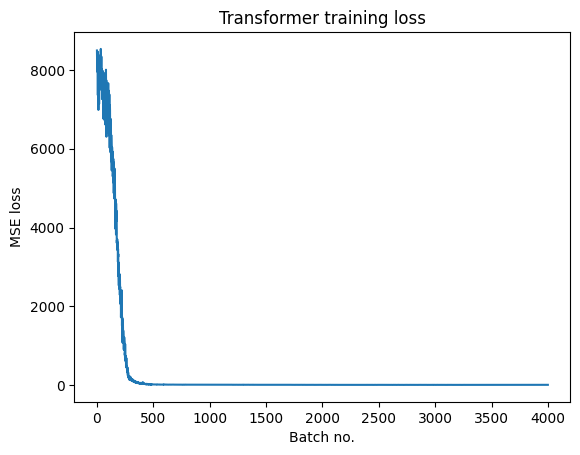

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Batch no.")
plt.ylabel("MSE loss")
plt.title("Transformer training loss")

In [ ]:
# Print model structure
print("Model structure:")
print(model)

Model structure:
ImprovedParticleTransformer(
  (embedding): ParticleEmbedding(
    (embedding): Sequential(
      (0): Linear(in_features=5, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (pos_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (feed_forward): Sequential(
   

Loss: 9.5706


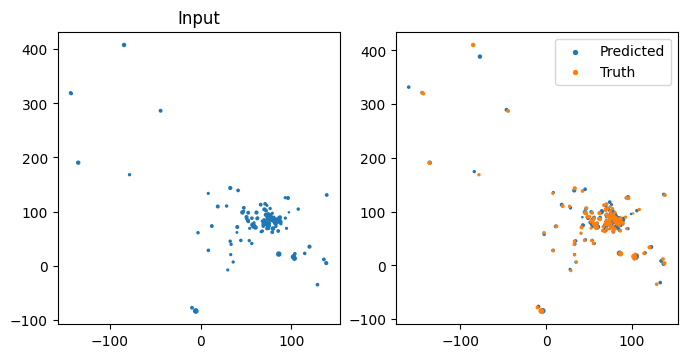

In [ ]:
def visualize_results(model, raw_inputs, raw_outputs, idx, device):
    x = raw_inputs[idx:idx+1].to(device)
    out = model(x)
    loss = nn.MSELoss()(out, x[...,:-1])

    m = x[0,:,-1].cpu()

    fig, axs = plt.subplots(1, 2, figsize=(8, 3.8))
    axs[0].scatter(*raw_inputs[idx][:,:2].T.cpu(), s=m)
    axs[0].set_title("Input")
    axs[1].scatter(*out[0][:,:2].T.cpu().detach().numpy(), s=m, label="Predicted")
    axs[1].scatter(*raw_outputs[idx][:,:2].T.cpu(), s=m, label="Truth")
    axs[1].legend()

    print(f"Loss: {loss.item():.4f}")
    return fig

# Visualize results
visualize_results(model, raw_inputs, raw_outputs, idx=210, device=device)
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import imageio
from pathlib import Path

def generate_simulation_video(model, initial_state, num_frames, save_path,
                            device='cuda', fps=30, figure_size=(5.12, 5.12),
                            dpi=100, bounds=(0, 128, 0, 128)):
    """
    Generate and save a video of particle simulation using the trained model.

    Args:
        model: Trained ParticleTransformer model
        initial_state: Initial particle state tensor [1, n_particles, features]
        num_frames: Number of frames to simulate
        save_path: Path to save the output video
        device: Device to run the model on
        fps: Frames per second for the output video
        figure_size: Size of the matplotlib figure
        dpi: DPI of the matplotlib figure
        bounds: Tuple of (x_min, x_max, y_min, y_max) for plot bounds
    """
    model.eval()
    frames = []
    current_state = initial_state.clone().to(device)

    # Extract masses from the initial state (last feature)
    masses = current_state[..., -1]
    sqrt_masses = torch.sqrt(masses)

    # Setup the figure
    fig, ax = plt.subplots(figsize=figure_size, dpi=dpi)
    fig.patch.set_facecolor('black')

    # Generate frames
    with torch.no_grad():
        for _ in tqdm(range(num_frames), desc="Generating frames", ncols=80):
            # Get current positions
            positions = current_state[0, :, :2].cpu()

            # Clear and setup the plot
            ax.clear()
            ax.set_xlim(bounds[0], bounds[1])
            ax.set_ylim(bounds[2], bounds[3])
            ax.scatter(positions[:, 0], positions[:, 1],
                      color="white", s=sqrt_masses.cpu())
            plt.axis("off")
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

            # Convert plot to image
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
            image = image.reshape(fig.canvas.get_width_height() + (4,))
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            image = image.copy()
            frames.append(image)

            # Predict next state
            predicted_deltas = model(current_state)

            # Update positions and velocities, keeping mass constant
            next_state = torch.zeros_like(current_state)
            next_state[..., :-1] = predicted_deltas  # Update positions and velocities
            next_state[..., -1] = current_state[..., -1]  # Keep masses unchanged
            current_state = next_state

    plt.close()

    # Save video
    print(f"Saving video to {save_path}...")
    imageio.mimsave(save_path, frames, fps=fps)
    print("Video saved successfully!")

    return frames

def generate_comparison_video(model, initial_state, ground_truth, save_path,
                            device='cuda', fps=30, figure_size=(10.24, 5.12),
                            dpi=100, bounds=(0, 128, 0, 128)):
    """
    Generate a side-by-side comparison video of model prediction vs ground truth.

    Args:
        model: Trained ParticleTransformer model
        initial_state: Initial particle state tensor [1, n_particles, features]
        ground_truth: Ground truth trajectory tensor [frames, n_particles, features]
        save_path: Path to save the output video
        device: Device to run the model on
        fps: Frames per second for the output video
        figure_size: Size of the matplotlib figure
        dpi: DPI of the matplotlib figure
        bounds: Tuple of (x_min, x_max, y_min, y_max) for plot bounds
    """
    model.eval()
    frames = []
    current_state = initial_state.clone().to(device)

    # Extract masses
    masses = current_state[..., -1]
    sqrt_masses = torch.sqrt(masses)

    # Setup the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figure_size, dpi=dpi)
    fig.patch.set_facecolor('black')

    # Generate frames
    with torch.no_grad():
        for frame_idx in tqdm(range(len(ground_truth)), desc="Generating comparison", ncols=80):
            # Get current positions
            predicted_positions = current_state[0, :, :2].cpu()
            true_positions = ground_truth[frame_idx, :, :2].cpu()

            # Clear and setup both plots
            for ax, positions, title in zip([ax1, ax2],
                                         [predicted_positions, true_positions],
                                         ['Prediction', 'Ground Truth']):
                ax.clear()
                ax.set_xlim(bounds[0], bounds[1])
                ax.set_ylim(bounds[2], bounds[3])
                ax.scatter(positions[:, 0], positions[:, 1],
                          color="white", s=sqrt_masses.cpu())
                ax.set_title(title, color='white')
                ax.set_facecolor('black')
                ax.axis("off")

            plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05)

            # Convert plot to image
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
            image = image.reshape(fig.canvas.get_width_height() + (4,))
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            image = image.copy()
            frames.append(image)

            # Predict next state
            predicted_deltas = model(current_state)

            # Update states
            next_state = torch.zeros_like(current_state)
            next_state[..., :-1] = predicted_deltas
            next_state[..., -1] = current_state[..., -1]
            current_state = next_state

    plt.close()

    # Save video
    print(f"Saving comparison video to {save_path}...")
    imageio.mimsave(save_path, frames, fps=fps)
    print("Comparison video saved successfully!")

    return frames

# Load initial state from your data
file = "n_128_dt_0.1_F_512/cloud/000001.pt"
timeline = torch.load(f"./data/{file}", weights_only=True)
initial_state = torch.cat([timeline['X'][0:1], timeline['V'][0:1],
                          timeline['m'][None, :, None]], dim=-1)

# Generate simulation video
generate_simulation_video(
    model=model,
    initial_state=initial_state,
    num_frames=512,
    save_path="simulation.mp4",
    device=device
)

# Generate comparison video
# generate_comparison_video(
#     model=model,
#     initial_state=initial_state,
#     ground_truth=torch.cat([timeline['X'], timeline['V'],
#                            timeline['m'][None, :, None].expand(512, -1, -1)], dim=-1),
#     save_path="comparison.mp4",
#     device=device
# )

Generating frames: 100%|██████████████████████| 512/512 [00:14<00:00, 36.00it/s]


Saving video to simulation.mp4...
Video saved successfully!


[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [ ]:
# Save the model weights
torch.save(model.state_dict(), "particle_transformer_weights.pth")
print("Model weights saved successfully.")


Model weights saved successfully.


In [ ]:
# Load the model weights
model = ImprovedParticleTransformer(
    input_dim=input_dim,
    d_model=512,
    num_heads=8,
    num_layers=8,
    d_ff=2048,
    dropout=0.1
).to(device)  # Ensure to match the architecture with the saved model

model.load_state_dict(torch.load("particle_transformer_weights.pth"))
print("Model weights loaded successfully.")


##Data Process#


In [ ]:
output_dir = 'processed_data'
combined_data_path = os.path.join(output_dir, 'combined_dataset_particle_wise.pt')
num_particles = 128
num_frames = 512


# Directory containing the .pt files
data_dir = 'data/n_128_dt_0.1_F_512/cloud'

# List to store the data frsom each file
data_list = []

# Iterate over all files in the directory
for file_name in tqdm(os.listdir(data_dir)):
    if file_name.endswith('.pt'):
        file_path = os.path.join(data_dir, file_name)
        data = torch.load(file_path)

        X = data['X']
        #print("X.shape", X.shape)

        V = data['V']
        #print("V.shape", V.shape)

        M = data['m']
        M_expanded = M.expand(num_frames, num_particles).unsqueeze(-1)
        #print("M_expanded.shape", M_expanded.shape)

        dt = torch.tensor(data['dt'])
        dt_expanded = dt.expand(num_frames, num_particles).unsqueeze(-1)
        #print("dt_expanded.shape", dt_expanded.shape)

        G = torch.tensor(data['G'])
        G_expanded = G.expand(num_frames, num_particles).unsqueeze(-1)
        #print("G_expanded.shape", G_expanded.shape)

        data = torch.cat([X, V, M_expanded, dt_expanded, G_expanded], dim=-1)
        #print("data.shape", data.shape)

        pairs = torch.stack([data[:-1], data[1:]], dim=1)

        data_list.append(pairs)

combined_data = torch.cat(data_list)
print(combined_data.shape)
# Save the combined dataset
torch.save(combined_data, combined_data_path)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-7-b2db4295d359>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)
100%|██████████| 100/100

torch.Size([51100, 2, 128, 7])
